# UMAP + HDBSCAN

In [1]:
import hdbscan
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import warnings
from umap import UMAP

warnings.filterwarnings("ignore", category=FutureWarning)


c:\Users\Usuario\anaconda3\envs\reto10_pyg\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# lectura del conjunto de datos
df = pd.read_csv('datos/df_final.csv', header=1)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_3820\3885903681.py:2: DtypeWarning: Columns (5,6,7,9,10,11,12,15,20,23,26,28,32,37,39,41,42,43,44,126) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('datos/df_final.csv', header=1)


In [3]:
# filtrar dataframe por pacientes con COVID19
df_covid = df[df['DIAG ING/INPAT'].str.contains('COVID19', na=False, case=False)]
print("Primeras filas del dataframe filtrado por COVID19:")
print(df_covid.head())

Primeras filas del dataframe filtrado por COVID19:
  GLU_ULTIMA/LAST_URG/EMERG DESTINO/DESTINY_URG/EMERG  \
0                         0                       NaN   
1                         0                   Ingreso   
2                         0                   Ingreso   
3                         0                   Ingreso   
4                         0                   Ingreso   

  TEMP_PRIMERA/FIRST_URG/EMERG MOTIVO_ALTA/DESTINY_DISCHARGE_ING  \
0                            0                         Domicilio   
1                            0                         Domicilio   
2                  37,09999847                         Domicilio   
3                           36                     Fallecimiento   
4                         37,8                         Domicilio   

  ESPECIALIDAD/DEPARTMENT_URG/EMERG TA_MIN_ULTIMA/LAST_URG/EMERG EDAD/AGE  \
0                               NaN                            0       75   
1             Medicina de Urgencias        

In [243]:
df_covid.describe()

,GLU_ULTIMA/LAST_URG/EMERG,DESTINO/DESTINY_URG/EMERG,TEMP_PRIMERA/FIRST_URG/EMERG,MOTIVO_ALTA/DESTINY_DISCHARGE_ING,ESPECIALIDAD/DEPARTMENT_URG/EMERG,TA_MIN_ULTIMA/LAST_URG/EMERG,EDAD/AGE,FC/HR_PRIMERA/FIRST_URG/EMERG,TEMP_ULTIMA/LAST_URG/EMERG,TA_MAX_ULTIMA/LAST_URGEMERG,...,PROC_13,PROC_04_DS6,POAD_09,NEO_06,DIA_12_DS6,PROC_07,PROC_19,PROC_10,PROC_17,DIA_05_DS6
count,4476,4398,4476,3990,4398,4476,4476,4476,4476,4476,...,328,4206,1884,0,1144,2486,86,872,122,3382
unique,30,2,54,5,9,83,88,103,57,133,...,59,112,3,0,274,96,31,85,39,546
top,0,Ingreso,0,Domicilio,Medicina de Urgencias,0,71,0,0,0,...,8E0ZXY6,3E013GC,S,NaN,Z79.82,8E0ZXY6,0TPBX0Z,8E0ZXY6,BW24ZZZ,I10
freq,4418,4394,994,3164,4062,1398,126,954,862,1396,...,52,580,1040,NaN,42,544,10,134,8,262


In [244]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7847 entries, 0 to 7846
Columns: 133 entries, GLU_ULTIMA/LAST_URG/EMERG to DIA_05_DS6
dtypes: object(133)
memory usage: 8.0+ MB


Para realizar el clustering, se necesitan decodificar los diagnosticos, por este motivo se realizan los siguientes preprocesamientos:

In [4]:
# filtrar columnas que empiezan por DIA_
df_covid_dia = df_covid.filter(regex='^DIA_')
# Mostrar las primeras filas del dataframe filtrado por DIA_
print("Primeras filas del dataframe filtrado por DIA_:")
print(df_covid_dia.head())

Primeras filas del dataframe filtrado por DIA_:
  DIA_PPAL_DS5 DIA_03_DS5 DIA_07_DS5 DIA_09_DS5 DIA_11_DS5 DIA_02_DS5  \
0      Z20.828        NaN        NaN        NaN        NaN      J98.8   
1        R91.8        NaN        NaN        NaN        NaN        NaN   
2       C79.10        NaN        NaN        NaN        NaN      G89.3   
3       I26.99        NaN        NaN        NaN        NaN      I50.9   
4     T45.1X5A     C81.90        NaN        NaN        NaN      R50.2   

  DIA_04_DS5 DIA_08_DS5 DIA_10_DS5 DIA_12_DS5  ... DIA_08_DS6  DIA_19  \
0        NaN        NaN        NaN        NaN  ...     L76.02   I50.9   
1        NaN        NaN        NaN        NaN  ...   T40.2X5A   Z88.2   
2        NaN        NaN        NaN        NaN  ...      D70.9  Z80.42   
3        NaN        NaN        NaN        NaN  ...     B97.29   R04.2   
4        NaN        NaN        NaN        NaN  ...      K25.4     E46   

    DIA_13 DIA_03_DS6 DIA_11_DS6 DIA_15 DIA_PPAL_DS6   DIA_17 DIA_12_DS6  

In [5]:
# crear columna que combina todos los valores de las columnas DIA_ y los separa por coma
df_covid_dia.loc[:, 'COMORBILIDADES/COMORBILITIES'] = df_covid_dia.apply(lambda x: ', '.join(x.dropna().astype(str)), axis=1)
# unir la columna al dataframe original df_covid
df_covid = df_covid.join(df_covid_dia['COMORBILIDADES/COMORBILITIES'])
df_covid['COMORBILIDADES/COMORBILITIES'].value_counts().head(10)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_3820\702205321.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_covid_dia.loc[:, 'COMORBILIDADES/COMORBILITIES'] = df_covid_dia.apply(lambda x: ', '.join(x.dropna().astype(str)), axis=1)


J18.9, B97.29, J12.89                            8
B34.2, B97.29, J12.89                            8
J18.9, R68.89, J18.9                             6
J18.9, R68.89, B97.29, J12.89                    6
B97.29, J98.8, B97.29, J12.89                    6
J12.89, B97.29, J18.9, B97.29, J96.00, J12.89    6
J18.9, Z20.828, R68.89, B97.29, J12.89           4
J12.89, B97.29, J12.89                           4
R68.89, J18.9, B97.29, J12.89                    4
R68.89, J18.9, B97.29, I10, J12.89               4
Name: COMORBILIDADES/COMORBILITIES, dtype: int64

In [6]:
# Una vez verifiques los nombres, selecciona las columnas correctas:
columnas = ['PATIENT ID', 'EDAD/AGE', 'SEXO/SEX', 'DIAG ING/INPAT',
                'FARMACO/DRUG_NOMBRE_COMERCIAL/COMERCIAL_NAME', 'UCI_DIAS/ICU_DAYS',
                'TEMP_ING/INPAT', 'SAT_02_ING/INPAT', 'RESULTADO/VAL_RESULT',
                'MOTIVO_ALTA/DESTINY_DISCHARGE_ING', 'COMORBILIDADES/COMORBILITIES']
    
df_covid = df_covid[columnas]
# Rellenar los valores nulos con 0
df_covid.fillna(0, inplace=True)
# Convertir las columnas numéricas a tipo float
# Convertir las columnas a numéricas, forzando errores a NaN y luego rellenando con 0 antes de convertir a int/float
df_covid['EDAD/AGE'] = pd.to_numeric(df_covid['EDAD/AGE'], errors='coerce').fillna(0).astype(int)
df_covid['PATIENT ID'] = pd.to_numeric(df_covid['PATIENT ID'], errors='coerce').fillna(0).astype(int)
df_covid['UCI_DIAS/ICU_DAYS'] = pd.to_numeric(df_covid['UCI_DIAS/ICU_DAYS'], errors='coerce').fillna(0).astype(int)
df_covid['TEMP_ING/INPAT'] = pd.to_numeric(df_covid['TEMP_ING/INPAT'], errors='coerce').fillna(0).astype(float)
df_covid['SAT_02_ING/INPAT'] = pd.to_numeric(df_covid['SAT_02_ING/INPAT'], errors='coerce').fillna(0).astype(int)
# imputar los valores 0 por la media de la columna
df_covid['UCI_DIAS/ICU_DAYS'] = df_covid['UCI_DIAS/ICU_DAYS'].replace(0, round(df_covid['UCI_DIAS/ICU_DAYS'].mean()))
df_covid['EDAD/AGE'] = df_covid['EDAD/AGE'].replace(0, round((df_covid['EDAD/AGE'].mean())))
df_covid['TEMP_ING/INPAT'] = df_covid['TEMP_ING/INPAT'].replace(0, round(df_covid['TEMP_ING/INPAT'].mean()))
df_covid['PATIENT ID'] = df_covid['PATIENT ID'].replace(0, round(df_covid['PATIENT ID'].mean()))
df_covid['SAT_02_ING/INPAT'] = df_covid['SAT_02_ING/INPAT'].replace(0, round(df_covid['SAT_02_ING/INPAT'].mean()))
# en MOTIVO_ALTA/DESTINY_DISCHARGE_ING sustituir los valores nulos por 'Domicilio'
df_covid['MOTIVO_ALTA/DESTINY_DISCHARGE_ING'] = df_covid['MOTIVO_ALTA/DESTINY_DISCHARGE_ING'].fillna('Domicilio')


Codificación CEI-10 de comorbilidades asociadas a COVID-19

Traducciones de Enfermedades al Inglés
Hipertensión arterial → Arterial hypertension / High blood pressure

Diabetes → Diabetes

Enfermedad cardiovascular → Cardiovascular disease

Enfermedad renal crónica → Chronic kidney disease

Enfermedad respiratoria crónica → Chronic respiratory disease

Obesidad → Obesity

Cáncer → Cancer

Inmunodeficiencia → Immunodeficiency

Enfermedad hepática → Liver disease

VIH/SIDA → HIV/AIDS

Tuberculosis activa → Active tuberculosis

Trastornos neurológicos → Neurological disorders

Trastornos de células falciformes → Sickle cell disorders

Tabaquismo → Smoking / Tobacco use disorder

In [7]:
dict_diagnosticos = {
    "HIPER_ART/ART_HYPER": ["G93.2", "I10", "I10.0", "I11.9", "I12.0", "I12.9", "I13.0", "I13.10", "I13.2", "I16.0", "I16.9", "I27.2", "I27.20", "I67.4", "K76.6"],
    "DIABETES/DIABETES": ["E09", "E09.649", "E09.65", "E09.9", "E10", "E10.319", "E10.65", "E10.9", "E11", "E11.22", "E11.40", "E11.42", "E11.51", "E11.59", "E11.621", "E11.649", "E11.65", "E11.9", "O24", "O24.410", "Z83.2", "Z86.32"],
    "ENF_CARDIO/CARDIO_DISEASE": ["I13.0", "I13.10", "I13.2", "I21.02", "I21.9", "I24.9", "I25.2", "I25.89", "I25.9", "I31.3", "I42.0", "I42.1", "I42.2", "I42.8", "I42.9", "I43", "I51.7", "R57.0"],
    "ENF_RENAL/KIDNEY_DISEASE": ["R39.2", "Q60.3", "N25.81", "N19", "N18.9", "N18.5", "N18.4", "N18.3", "N18.2", "N18.1", "N17.9", "N17.0", "I72.2", "I12.9", "I12.0", "E27.9", "E11.22", "D63.1"],
    "ENF_RESPIRA/RESPI_DISEASE": ["B09.9", "J06.9", "J68.4", "J80", "J95.821", "J96", "J96.0", "J96.00", "J96.01", "J96.02", "J96.1", "J96.10", "J96.2", "J96.20", "J96.21", "J96.22", "J96.9", "J96.90", "J96.91", "J96.92", "J98.8"],
    "OBESITIDAD/OBESITY": ["E66.01", "E66.2", "E66.8", "E66.9"],
    "CANCER/CANCER": ["C03.0", "C15.9", "C16.0", "C16.9", "C18.1", "C18.4", "C18.7", "C18.9", "C19", "C20", "C21.10", "C22.0", "C22.1", "C24.0", "C25.0", "C25.9", "C34", "C34.01", "C34.11", "C34.12", "C34.21", "C34.32", "C34.90", "C34.91", "C43.72", "C43.9", "C45", "C45.0", "C50", "C50.211", "C50.911", "C50.912", "C50.919", "C50.929", "C61", "C64.1", "C64.2", "C67.9", "C71.2", "C76.3", "C77.1", "C77.2", "C77.8", "C77.9", "C78.00", "C78.01", "C78.02", "C78.2", "C78.4", "C78.6", "C78.7", "C79.02", "C79.31", "C79.51", "C79.52", "C79.71", "C79.89", "C7A.00", "C7A.1", "C7B.01", "C7B.02", "C7B.03", "C77B.09", "C7B.8", "C80.0", "C81.90", "C82.09", "C82.10", "C82.40", "C82.90", "C82.99", "C83.03", "C83.09", "C83.31", "C83.39", "C83.28", "C85.90", "D12.5", "D12.6", "D13.4", "D16.01", "D16.5", "D17.23", "D17.71", "D17.79", "D18.02", "D18.03", "D18.09", "D32.0", "D32.9", "D33.3", "D35.01", "D38.1", "8000/3", "8010/3", "8140/3", "8070/3", "9590/3"],
    "INMUNO/IMMUNO": ["D80.3", "D81.89", "D83.9", "Z87.72"],
    "ENF_HEPATICA/LIVER_DISEASE": ["B19.10", "B19.20", "C22.1", "K70.30", "K70.31", "K70.40", "K70.9", "K71.10", "K71.8", "K71.9", "K72.00", "K72.90", "K74.5", "K74.60"],
    "VIH/SIDA": ["B20"],
    "TUBERCULOSIS/TUBERCULOSIS": ["A15.0", "B90.9", "Z86.11"],
    "TRAST_NEURO/NEURO_DISORDERS": ["G21.0", "I69.198", "I69.398", "I69.818"],
    "TRAST_CEL_FALCI/SICKLE_CELL_DIS": ["D57.0", "D57.1", "D57.2", "D57.3", "D57.4", "D57.8", "D57.9"],
    "TABAQUISMO/SMOKING": ["F17.200", "F17.201", "F17.203", "F17.204", "F17.205", "F17.206", "F17.207", "F17.208", "F17.209", "F17.210", "F17.211", "F17.212", "F17.213", "F17.214", "F17.215", "F17.216", "F17.217", "F17.218", "F17.219", "O99.335"]
}

In [8]:
for tipo, codigos in dict_diagnosticos.items():
    df_covid.loc[:, tipo] = df_covid['COMORBILIDADES/COMORBILITIES'].apply(lambda x: 1 if any(codigo in str(x) for codigo in codigos) else 0)


# Análisis de clústeres de Ingresados por COVID-19 y comorbilidades

In [9]:
# eliminar columnas FARMACO/DRUG_NOMBRE_COMERCIAL/COMERCIAL_NAME, TEMP_ING/INPAT, SAT_02_ING/INPAT
df_comorbilidades = df_covid.drop(columns=['FARMACO/DRUG_NOMBRE_COMERCIAL/COMERCIAL_NAME', 'TEMP_ING/INPAT', 'SAT_02_ING/INPAT', 'RESULTADO/VAL_RESULT', 'MOTIVO_ALTA/DESTINY_DISCHARGE_ING', 'DIAG ING/INPAT', 'COMORBILIDADES/COMORBILITIES'])
df_comorbilidades.head(5)

,PATIENT ID,EDAD/AGE,SEXO/SEX,UCI_DIAS/ICU_DAYS,HIPER_ART/ART_HYPER,DIABETES/DIABETES,ENF_CARDIO/CARDIO_DISEASE,ENF_RENAL/KIDNEY_DISEASE,ENF_RESPIRA/RESPI_DISEASE,OBESITIDAD/OBESITY,CANCER/CANCER,INMUNO/IMMUNO,ENF_HEPATICA/LIVER_DISEASE,VIH/SIDA,TUBERCULOSIS/TUBERCULOSIS,TRAST_NEURO/NEURO_DISORDERS,TRAST_CEL_FALCI/SICKLE_CELL_DIS,TABAQUISMO/SMOKING
0,44,75,FEMALE,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,585,62,FEMALE,10,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,587,69,MALE,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,586,67,FEMALE,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0
4,588,72,MALE,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0


In [10]:
# binarizar columna SEXO/SEX FEMALE = 0 , MALE = 1
df_comorbilidades['SEXO/SEX'] = df_comorbilidades['SEXO/SEX'].map({'FEMALE': 0, 'MALE': 1})


In [11]:
# cambiar formato de la columna EDAD/AGE a int
df_comorbilidades['EDAD/AGE'] = df_comorbilidades['EDAD/AGE'].astype(int)
# cambiar formato de la columna SEXO/AGE a int
df_comorbilidades['SEXO/SEX'] = df_comorbilidades['SEXO/SEX'].astype(int)

In [12]:
# se susituyen los valores NaN de la columna UCI_DIAS/ICU_DAYS por la media de la columna
df_comorbilidades.fillna({'UCI_DIAS/ICU_DAYS': df_comorbilidades['UCI_DIAS/ICU_DAYS'].mean()}, inplace=True)
# se transforma la columna UCI_DIAS/ICU_DAYS a int
df_comorbilidades['UCI_DIAS/ICU_DAYS'] = df_comorbilidades['UCI_DIAS/ICU_DAYS'].astype(int)


In [13]:
# normalizar la columna EDAD/AGE
scaler = MinMaxScaler()
df_comorbilidades_encoded = df_comorbilidades.copy()
# normalizar el dataset
df_comorbilidades_encoded = pd.DataFrame(scaler.fit_transform(df_comorbilidades_encoded), columns=df_comorbilidades_encoded.columns)
df_comorbilidades_encoded

,PATIENT ID,EDAD/AGE,SEXO/SEX,UCI_DIAS/ICU_DAYS,HIPER_ART/ART_HYPER,DIABETES/DIABETES,ENF_CARDIO/CARDIO_DISEASE,ENF_RENAL/KIDNEY_DISEASE,ENF_RESPIRA/RESPI_DISEASE,OBESITIDAD/OBESITY,CANCER/CANCER,INMUNO/IMMUNO,ENF_HEPATICA/LIVER_DISEASE,VIH/SIDA,TUBERCULOSIS/TUBERCULOSIS,TRAST_NEURO/NEURO_DISORDERS,TRAST_CEL_FALCI/SICKLE_CELL_DIS,TABAQUISMO/SMOKING
0,0.018542,0.704762,0.0,0.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.251833,0.580952,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.252695,0.647619,1.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.252264,0.628571,0.0,0.00,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.253126,0.676190,1.0,0.00,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4471,0.120310,0.819048,1.0,0.00,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4472,0.117292,0.485714,0.0,0.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4473,0.122467,0.742857,1.0,0.00,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4474,0.123329,0.323810,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# se agrupan las variables de comorbilidades en un dataframe
df_comorbilidades_grouped = df_comorbilidades.groupby(['HIPER_ART/ART_HYPER', 'DIABETES/DIABETES', 'ENF_CARDIO/CARDIO_DISEASE', 'ENF_RENAL/KIDNEY_DISEASE', 'ENF_RESPIRA/RESPI_DISEASE', 'OBESITIDAD/OBESITY', 'CANCER/CANCER', 'INMUNO/IMMUNO', 'ENF_HEPATICA/LIVER_DISEASE', 'VIH/SIDA', 'TUBERCULOSIS/TUBERCULOSIS', 'TRAST_NEURO/NEURO_DISORDERS', 'TRAST_CEL_FALCI/SICKLE_CELL_DIS', 'TABAQUISMO/SMOKING']).size().reset_index(name='counts')
# Mostrar el dataframe agrupado
print("Dataframe agrupado por comorbilidades:")
df_comorbilidades_grouped = df_comorbilidades_grouped.sort_values(by='counts', ascending=False)
df_comorbilidades_grouped.reset_index(drop=True, inplace=True)
# añadir una columna de porcentaje
df_comorbilidades_grouped['percentage'] = (df_comorbilidades_grouped['counts'] / df_comorbilidades_grouped['counts'].sum()) * 100
# Mostrar el dataframe agrupado
print(df_comorbilidades_grouped[0:5])
print(type(df_comorbilidades_grouped))


Dataframe agrupado por comorbilidades:
   HIPER_ART/ART_HYPER  DIABETES/DIABETES  ENF_CARDIO/CARDIO_DISEASE  \
0                    0                  0                          0   
1                    0                  0                          0   
2                    1                  0                          0   
3                    1                  0                          0   
4                    1                  1                          0   

   ENF_RENAL/KIDNEY_DISEASE  ENF_RESPIRA/RESPI_DISEASE  OBESITIDAD/OBESITY  \
0                         0                          1                   0   
1                         0                          0                   0   
2                         0                          1                   0   
3                         0                          0                   0   
4                         0                          1                   0   

   CANCER/CANCER  INMUNO/IMMUNO  ENF_HEPATICA/LIVER_DISEASE

In [82]:
def plot_umap_hdbscan(df, min_cluster_size):
    df_umap = umap_df(df)
    print(len(df_umap))
    # Crear el objeto HDBSCAN
    if min_cluster_size == 1:
        min_cluster_size = 2
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=20)

    # Ajustar el modelo a los datos
    clusterer.fit(df_umap)

    # Obtener las etiquetas de cluster (-1 significa ruido)
    labels = clusterer.labels_

    # Calcular el número de clusters encontrados
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    prob_umap = clusterer.probabilities_

    print(f"Número de clusters encontrados: {n_clusters}")
    print(f"Número de puntos de anomalías: {n_noise}")

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(
        df_umap['UMAP1'],
        df_umap['UMAP2'],
        c=labels,
        cmap='viridis',
        s=50,
        alpha=0.7
    )
    plt.title('UMAP: Clusters coloreados por etiqueta')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.colorbar(label='Etiqueta del Cluster')

    plt.subplot(1, 2, 2)
    high_prob_mask_umap = prob_umap > 0.5
    unique_labels_umap = set(labels)
    colors_umap = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels_umap))]

    for k, col in zip(unique_labels_umap, colors_umap):
        if k == -1:
            col = [0, 0, 0, 1]
        class_mask_umap = (labels == k)
        
        # Puntos “core” (alta probabilidad)
        high_points_umap = df_umap[class_mask_umap & high_prob_mask_umap]
        if len(high_points_umap) > 0:
            plt.scatter(
                high_points_umap['UMAP1'],
                high_points_umap['UMAP2'],
                c=[col],
                s=100,           # más grandes para core points
                alpha=0.8,
                edgecolors='k',
                linewidth=1
            )
        
        # Puntos “edge” (baja probabilidad)
        low_points_umap = df_umap[class_mask_umap & ~high_prob_mask_umap]
        if len(low_points_umap) > 0:
            plt.scatter(
                low_points_umap['UMAP1'],
                low_points_umap['UMAP2'],
                c=[col],
                s=30,            # más pequeños para edge points
                alpha=0.6,
                edgecolors='k',
                linewidth=0.5
            )

    plt.title('UMAP: HDBSCAN (tamaño ∝ probabilidad)')
    plt.tight_layout()
    plt.show()

In [15]:
# Perfil de comorbilidades del grupo 1: Covid-19 con enf. respiratoria
df_comorbilidades_grupo_1 = df_comorbilidades[(df_comorbilidades['HIPER_ART/ART_HYPER'] == 0) &
(df_comorbilidades['DIABETES/DIABETES'] == 0) &
(df_comorbilidades['ENF_CARDIO/CARDIO_DISEASE'] == 0) &
(df_comorbilidades['ENF_RENAL/KIDNEY_DISEASE'] == 0) &
(df_comorbilidades['ENF_RESPIRA/RESPI_DISEASE'] == 1) &
(df_comorbilidades['OBESITIDAD/OBESITY'] == 0) &
(df_comorbilidades['CANCER/CANCER'] == 0) &
(df_comorbilidades['INMUNO/IMMUNO'] == 0) &
(df_comorbilidades['ENF_HEPATICA/LIVER_DISEASE'] == 0) &
(df_comorbilidades['VIH/SIDA'] == 0) &
(df_comorbilidades['TUBERCULOSIS/TUBERCULOSIS'] == 0) &
(df_comorbilidades['TRAST_NEURO/NEURO_DISORDERS'] == 0) &
(df_comorbilidades['TRAST_CEL_FALCI/SICKLE_CELL_DIS'] == 0) &
(df_comorbilidades['TABAQUISMO/SMOKING'] == 0)]

In [257]:
df_comorbilidades_grupo_1.describe()

,PATIENT ID,EDAD/AGE,SEXO/SEX,UCI_DIAS/ICU_DAYS,HIPER_ART/ART_HYPER,DIABETES/DIABETES,ENF_CARDIO/CARDIO_DISEASE,ENF_RENAL/KIDNEY_DISEASE,ENF_RESPIRA/RESPI_DISEASE,OBESITIDAD/OBESITY,CANCER/CANCER,INMUNO/IMMUNO,ENF_HEPATICA/LIVER_DISEASE,VIH/SIDA,TUBERCULOSIS/TUBERCULOSIS,TRAST_NEURO/NEURO_DISORDERS,TRAST_CEL_FALCI/SICKLE_CELL_DIS,TABAQUISMO/SMOKING
count,1088.000000,1088.000000,1088.000000,1088.000000,1088.0,1088.0,1088.0,1088.0,1088.0,1088.0,1088.0,1088.0,1088.0,1088.0,1088.0,1088.0,1088.0,1088.0
mean,1164.906250,63.308824,0.586397,1.470588,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,652.501478,15.594453,0.492705,2.632865,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,5.000000,1.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,659.750000,52.750000,0.000000,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,1171.000000,63.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1722.500000,74.250000,1.000000,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,2319.000000,102.000000,1.000000,34.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Grupo 1: Pacientes con covid-19 y enfermedades respiratorias crónicas
- Media de edad: 63 años
- Rango de edad: 1 a 102 años
- Media de días de hospitalización: 1.47
- Pacientes: 544

In [26]:
def umap_df(df):
    reducer = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
    X = reducer.fit_transform(df)
    return pd.DataFrame(
                X,
                index=df.index,
                columns=['UMAP1', 'UMAP2']
            )

In [50]:
# Criterio estadístico para el tamaño mínimo de los clusters
dataset_size = len(df_comorbilidades_grupo_1)
min_cluster_size = int(dataset_size * 0.02)
print(f"Minimum cluster size: {min_cluster_size}")


Minimum cluster size: 21


c:\Users\Usuario\anaconda3\envs\reto10_pyg\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


1088
Número de clusters encontrados: 12
Número de puntos de anomalías: 16


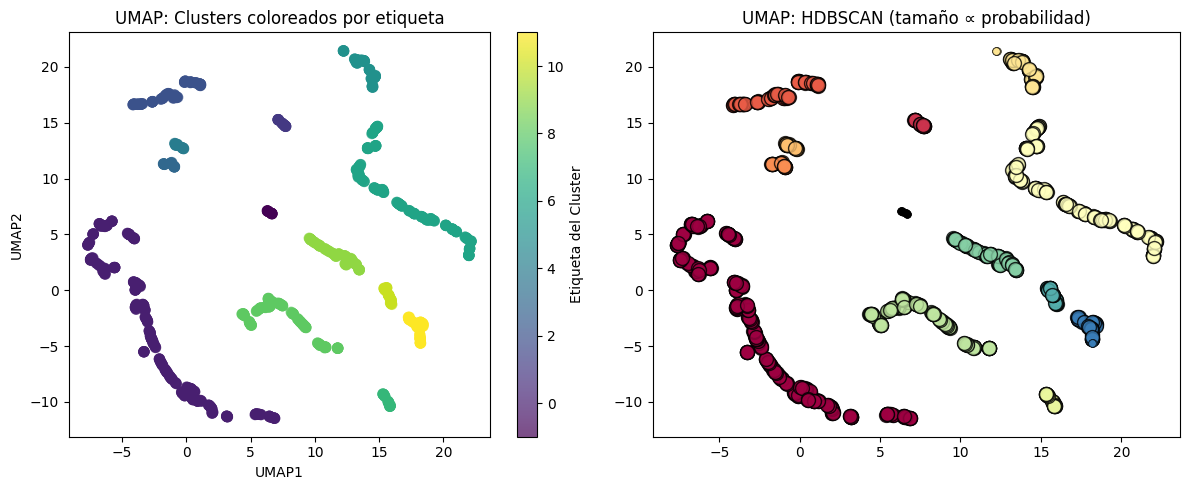

In [51]:
plot_umap_hdbscan(df_comorbilidades_grupo_1, min_cluster_size)

In [52]:
# Pacientes con covid-19 sin comorbilidades
df_comorbilidades_grupo_2 = df_comorbilidades[(df_comorbilidades['HIPER_ART/ART_HYPER'] == 0) &
(df_comorbilidades['DIABETES/DIABETES'] == 0) &
(df_comorbilidades['ENF_CARDIO/CARDIO_DISEASE'] == 0) &
(df_comorbilidades['ENF_RENAL/KIDNEY_DISEASE'] == 0) &
(df_comorbilidades['ENF_RESPIRA/RESPI_DISEASE'] == 0) &
(df_comorbilidades['OBESITIDAD/OBESITY'] == 0) &
(df_comorbilidades['CANCER/CANCER'] == 0) &
(df_comorbilidades['INMUNO/IMMUNO'] == 0) &
(df_comorbilidades['ENF_HEPATICA/LIVER_DISEASE'] == 0) &
(df_comorbilidades['VIH/SIDA'] == 0) &
(df_comorbilidades['TUBERCULOSIS/TUBERCULOSIS'] == 0) &
(df_comorbilidades['TRAST_NEURO/NEURO_DISORDERS'] == 0) &
(df_comorbilidades['TRAST_CEL_FALCI/SICKLE_CELL_DIS'] == 0) &
(df_comorbilidades['TABAQUISMO/SMOKING'] == 0)]

In [53]:
df_comorbilidades_grupo_2.describe()

,PATIENT ID,EDAD/AGE,SEXO/SEX,UCI_DIAS/ICU_DAYS,HIPER_ART/ART_HYPER,DIABETES/DIABETES,ENF_CARDIO/CARDIO_DISEASE,ENF_RENAL/KIDNEY_DISEASE,ENF_RESPIRA/RESPI_DISEASE,OBESITIDAD/OBESITY,CANCER/CANCER,INMUNO/IMMUNO,ENF_HEPATICA/LIVER_DISEASE,VIH/SIDA,TUBERCULOSIS/TUBERCULOSIS,TRAST_NEURO/NEURO_DISORDERS,TRAST_CEL_FALCI/SICKLE_CELL_DIS,TABAQUISMO/SMOKING
count,822.000000,822.00000,822.000000,822.000000,822.0,822.0,822.0,822.0,822.0,822.0,822.0,822.0,822.0,822.0,822.0,822.0,822.0,822.0
mean,1163.518248,57.00000,0.562044,1.026764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,656.951307,15.60833,0.496438,0.378167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,6.000000,15.00000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,680.000000,45.00000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,1128.000000,56.00000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1741.500000,68.00000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,2320.000000,97.00000,1.000000,8.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Grupo 2: Pacientes con covid-19
- Media de edad: 57 años
- Rango de edad: 15 a 97 años
- media de días de hospitalización: 1.02
- Pacientes: 822

In [54]:
# Criterio estadístico para el tamaño mínimo de los clusters
dataset_size = len(df_comorbilidades_grupo_2)
min_cluster_size = int(dataset_size * 0.02)  # 2% = 20 puntos
print(f"Minimum cluster size: {min_cluster_size}")


Minimum cluster size: 16


c:\Users\Usuario\anaconda3\envs\reto10_pyg\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


822
Número de clusters encontrados: 17
Número de puntos de anomalías: 8


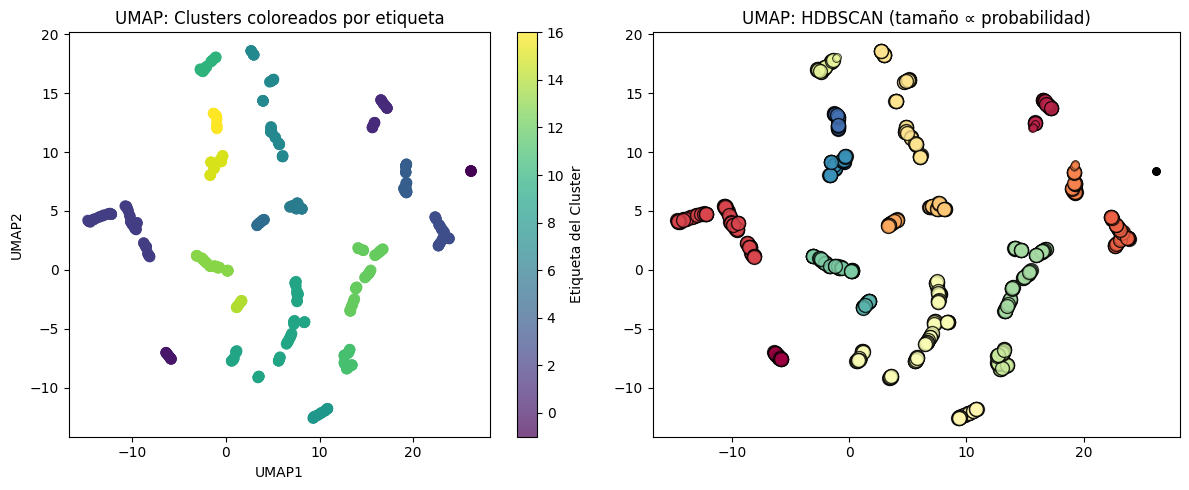

In [55]:
plot_umap_hdbscan(df_comorbilidades_grupo_2, min_cluster_size)

In [56]:
# Paciente con covid-19, hipertensión y enf. respiratoria
df_comorbilidades_grupo_3 = df_comorbilidades[(df_comorbilidades['HIPER_ART/ART_HYPER'] == 1) &
(df_comorbilidades['DIABETES/DIABETES'] == 0) &
(df_comorbilidades['ENF_CARDIO/CARDIO_DISEASE'] == 0) &
(df_comorbilidades['ENF_RENAL/KIDNEY_DISEASE'] == 0) &
(df_comorbilidades['ENF_RESPIRA/RESPI_DISEASE'] == 1) &
(df_comorbilidades['OBESITIDAD/OBESITY'] == 0) &
(df_comorbilidades['CANCER/CANCER'] == 0) &
(df_comorbilidades['INMUNO/IMMUNO'] == 0) &
(df_comorbilidades['ENF_HEPATICA/LIVER_DISEASE'] == 0) &
(df_comorbilidades['VIH/SIDA'] == 0) &
(df_comorbilidades['TUBERCULOSIS/TUBERCULOSIS'] == 0) &
(df_comorbilidades['TRAST_NEURO/NEURO_DISORDERS'] == 0) &
(df_comorbilidades['TRAST_CEL_FALCI/SICKLE_CELL_DIS'] == 0) &
(df_comorbilidades['TABAQUISMO/SMOKING'] == 0)]

In [57]:
df_comorbilidades_grupo_3.describe()

,PATIENT ID,EDAD/AGE,SEXO/SEX,UCI_DIAS/ICU_DAYS,HIPER_ART/ART_HYPER,DIABETES/DIABETES,ENF_CARDIO/CARDIO_DISEASE,ENF_RENAL/KIDNEY_DISEASE,ENF_RESPIRA/RESPI_DISEASE,OBESITIDAD/OBESITY,CANCER/CANCER,INMUNO/IMMUNO,ENF_HEPATICA/LIVER_DISEASE,VIH/SIDA,TUBERCULOSIS/TUBERCULOSIS,TRAST_NEURO/NEURO_DISORDERS,TRAST_CEL_FALCI/SICKLE_CELL_DIS,TABAQUISMO/SMOKING
count,530.000000,530.000000,530.000000,530.000000,530.0,530.0,530.0,530.0,530.0,530.0,530.0,530.0,530.0,530.0,530.0,530.0,530.0,530.0
mean,1187.026415,75.033962,0.532075,1.486792,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,640.644609,11.909980,0.499441,2.996030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,16.000000,47.000000,0.000000,1.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,698.000000,67.000000,0.000000,1.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,1236.000000,75.000000,1.000000,1.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1699.000000,85.000000,1.000000,1.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,2316.000000,99.000000,1.000000,37.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Grupo 3: Pacientes con covid-19, hipertensión arterial y enfermedad respitatoria crónica
- Media de edad: 75 años
- Rango de edad: 47 a 99 años
- media de días de hospitalización: 1.48
- Pacientes: 530

In [58]:
# criterio estadístico para el tamaño mínimo de los clusters
dataset_size = len(df_comorbilidades_grupo_3)
min_cluster_size = int(dataset_size * 0.02)
print(f"Minimum cluster size: {min_cluster_size}")

Minimum cluster size: 10


c:\Users\Usuario\anaconda3\envs\reto10_pyg\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


530
Número de clusters encontrados: 11
Número de puntos de anomalías: 21


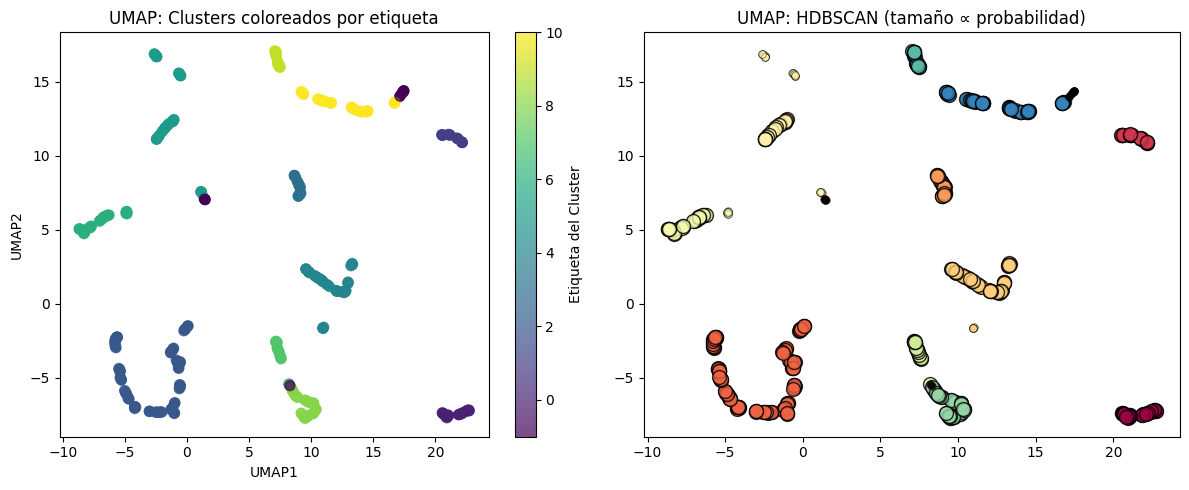

In [59]:
plot_umap_hdbscan(df_comorbilidades_grupo_3, min_cluster_size)

In [60]:
# Paciente con covid-19 e hipertensión
df_comorbilidades_grupo_4 = df_comorbilidades[(df_comorbilidades['HIPER_ART/ART_HYPER'] == 1) &
(df_comorbilidades['DIABETES/DIABETES'] == 0) &
(df_comorbilidades['ENF_CARDIO/CARDIO_DISEASE'] == 0) &
(df_comorbilidades['ENF_RENAL/KIDNEY_DISEASE'] == 0) &
(df_comorbilidades['ENF_RESPIRA/RESPI_DISEASE'] == 0) &
(df_comorbilidades['OBESITIDAD/OBESITY'] == 0) &
(df_comorbilidades['CANCER/CANCER'] == 0) &
(df_comorbilidades['INMUNO/IMMUNO'] == 0) &
(df_comorbilidades['ENF_HEPATICA/LIVER_DISEASE'] == 0) &
(df_comorbilidades['VIH/SIDA'] == 0) &
(df_comorbilidades['TUBERCULOSIS/TUBERCULOSIS'] == 0) &
(df_comorbilidades['TRAST_NEURO/NEURO_DISORDERS'] == 0) &
(df_comorbilidades['TRAST_CEL_FALCI/SICKLE_CELL_DIS'] == 0) &
(df_comorbilidades['TABAQUISMO/SMOKING'] == 0)]

In [61]:
df_comorbilidades_grupo_4.describe()

,PATIENT ID,EDAD/AGE,SEXO/SEX,UCI_DIAS/ICU_DAYS,HIPER_ART/ART_HYPER,DIABETES/DIABETES,ENF_CARDIO/CARDIO_DISEASE,ENF_RENAL/KIDNEY_DISEASE,ENF_RESPIRA/RESPI_DISEASE,OBESITIDAD/OBESITY,CANCER/CANCER,INMUNO/IMMUNO,ENF_HEPATICA/LIVER_DISEASE,VIH/SIDA,TUBERCULOSIS/TUBERCULOSIS,TRAST_NEURO/NEURO_DISORDERS,TRAST_CEL_FALCI/SICKLE_CELL_DIS,TABAQUISMO/SMOKING
count,306.000000,306.000000,306.000000,306.000000,306.0,306.0,306.0,306.0,306.0,306.0,306.0,306.0,306.0,306.0,306.0,306.0,306.0,306.0
mean,1200.614379,70.588235,0.581699,1.098039,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,648.578573,13.780732,0.494088,0.831863,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,2.000000,39.000000,0.000000,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,617.000000,61.000000,0.000000,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,1209.000000,71.000000,1.000000,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1664.000000,80.000000,1.000000,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,2305.000000,99.000000,1.000000,10.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Grupo 4: Pacientes con covid-19 e hipertensión arterial
- Media de edad: 70 años
- Rango de edad: 39 a 99 años
- media de días de hospitalización: 1.09
- Pacientes: 306

In [62]:
# Criterio de selección del tamaño mínimo de los clusters
dataset_size = len(df_comorbilidades_grupo_4)
min_cluster_size = int(dataset_size * 0.02)
print(f"Minimum cluster size: {min_cluster_size}")

Minimum cluster size: 6


c:\Users\Usuario\anaconda3\envs\reto10_pyg\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


1088
Número de clusters encontrados: 12
Número de puntos de anomalías: 16


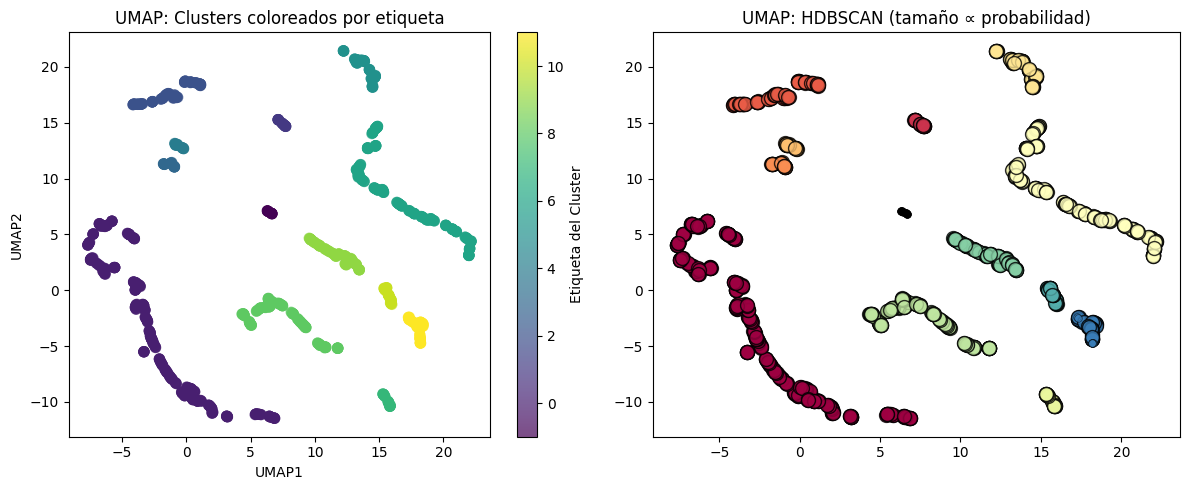

In [63]:
plot_umap_hdbscan(df_comorbilidades_grupo_1, min_cluster_size)

In [64]:
# Paciente con covid-19, hipertension, diabetes y enf. respiratoria
df_comorbilidades_grupo_5 = df_comorbilidades[(df_comorbilidades['HIPER_ART/ART_HYPER'] == 1) &
(df_comorbilidades['DIABETES/DIABETES'] == 1) &
(df_comorbilidades['ENF_CARDIO/CARDIO_DISEASE'] == 0) &
(df_comorbilidades['ENF_RENAL/KIDNEY_DISEASE'] == 0) &
(df_comorbilidades['ENF_RESPIRA/RESPI_DISEASE'] == 1) &
(df_comorbilidades['OBESITIDAD/OBESITY'] == 0) &
(df_comorbilidades['CANCER/CANCER'] == 0) &
(df_comorbilidades['INMUNO/IMMUNO'] == 0) &
(df_comorbilidades['ENF_HEPATICA/LIVER_DISEASE'] == 0) &
(df_comorbilidades['VIH/SIDA'] == 0) &
(df_comorbilidades['TUBERCULOSIS/TUBERCULOSIS'] == 0) &
(df_comorbilidades['TRAST_NEURO/NEURO_DISORDERS'] == 0) &
(df_comorbilidades['TRAST_CEL_FALCI/SICKLE_CELL_DIS'] == 0) &
(df_comorbilidades['TABAQUISMO/SMOKING'] == 0)]

In [65]:
df_comorbilidades_grupo_5.describe()

,PATIENT ID,EDAD/AGE,SEXO/SEX,UCI_DIAS/ICU_DAYS,HIPER_ART/ART_HYPER,DIABETES/DIABETES,ENF_CARDIO/CARDIO_DISEASE,ENF_RENAL/KIDNEY_DISEASE,ENF_RESPIRA/RESPI_DISEASE,OBESITIDAD/OBESITY,CANCER/CANCER,INMUNO/IMMUNO,ENF_HEPATICA/LIVER_DISEASE,VIH/SIDA,TUBERCULOSIS/TUBERCULOSIS,TRAST_NEURO/NEURO_DISORDERS,TRAST_CEL_FALCI/SICKLE_CELL_DIS,TABAQUISMO/SMOKING
count,138.000000,138.000000,138.000000,138.000000,138.0,138.0,138.0,138.0,138.0,138.0,138.0,138.0,138.0,138.0,138.0,138.0,138.0,138.0
mean,1185.057971,75.594203,0.695652,1.159420,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,704.480010,10.366029,0.461807,1.319403,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,75.000000,53.000000,0.000000,1.000000,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,516.000000,67.000000,0.000000,1.000000,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,1219.000000,76.000000,1.000000,1.000000,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1827.000000,83.000000,1.000000,1.000000,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,2248.000000,98.000000,1.000000,12.000000,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Grupo 5: Pacientes con covid-19, hipertensión arterial, diabetes y enfermedad respiratoria crónica
- Media de edad: 75 años
- Rango de edad: 53 a 98 años
- media de días de hospitalización: 1.15
- Pacientes: 138

In [66]:
# criterio estadístico para el tamaño mínimo de los clusters
dataset_size = len(df_comorbilidades_grupo_5)
min_cluster_size = int(dataset_size * 0.02)
print(f"Minimum cluster size: {min_cluster_size}")

Minimum cluster size: 2


c:\Users\Usuario\anaconda3\envs\reto10_pyg\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


138
Número de clusters encontrados: 2
Número de puntos de anomalías: 0


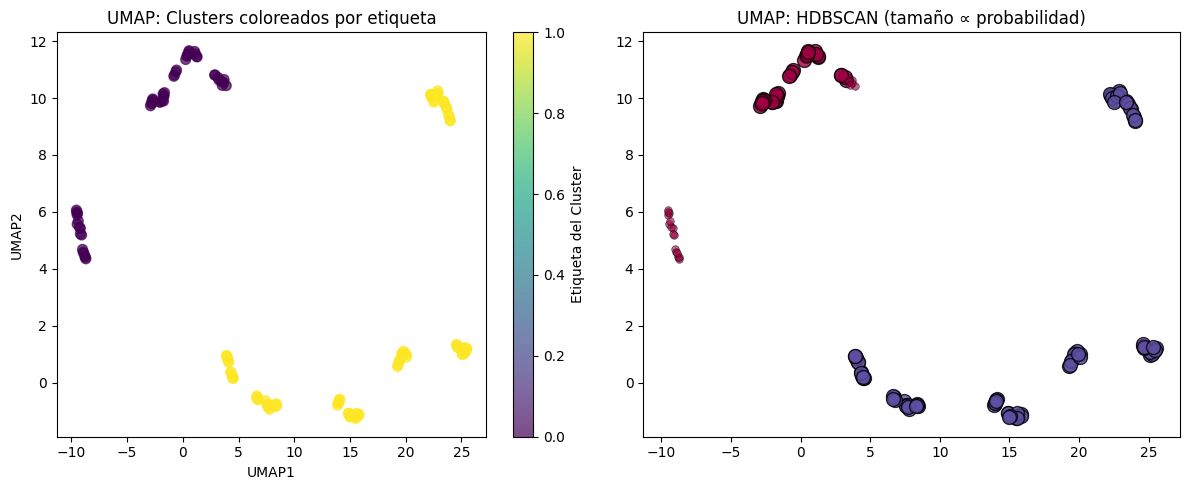

In [67]:
plot_umap_hdbscan(df_comorbilidades_grupo_5, min_cluster_size)

In [68]:
# Paciente con covid-19, hipertension, enf. renal y respiratoria
df_comorbilidades_grupo_6 = df_comorbilidades[(df_comorbilidades['HIPER_ART/ART_HYPER'] == 1) &
(df_comorbilidades['DIABETES/DIABETES'] == 0) &
(df_comorbilidades['ENF_CARDIO/CARDIO_DISEASE'] == 0) &
(df_comorbilidades['ENF_RENAL/KIDNEY_DISEASE'] == 1) &
(df_comorbilidades['ENF_RESPIRA/RESPI_DISEASE'] == 1) &
(df_comorbilidades['OBESITIDAD/OBESITY'] == 0) &
(df_comorbilidades['CANCER/CANCER'] == 0) &
(df_comorbilidades['INMUNO/IMMUNO'] == 0) &
(df_comorbilidades['ENF_HEPATICA/LIVER_DISEASE'] == 0) &
(df_comorbilidades['VIH/SIDA'] == 0) &
(df_comorbilidades['TUBERCULOSIS/TUBERCULOSIS'] == 0) &
(df_comorbilidades['TRAST_NEURO/NEURO_DISORDERS'] == 0) &
(df_comorbilidades['TRAST_CEL_FALCI/SICKLE_CELL_DIS'] == 0) &
(df_comorbilidades['TABAQUISMO/SMOKING'] == 0)]

In [69]:
df_comorbilidades_grupo_6.describe()

,PATIENT ID,EDAD/AGE,SEXO/SEX,UCI_DIAS/ICU_DAYS,HIPER_ART/ART_HYPER,DIABETES/DIABETES,ENF_CARDIO/CARDIO_DISEASE,ENF_RENAL/KIDNEY_DISEASE,ENF_RESPIRA/RESPI_DISEASE,OBESITIDAD/OBESITY,CANCER/CANCER,INMUNO/IMMUNO,ENF_HEPATICA/LIVER_DISEASE,VIH/SIDA,TUBERCULOSIS/TUBERCULOSIS,TRAST_NEURO/NEURO_DISORDERS,TRAST_CEL_FALCI/SICKLE_CELL_DIS,TABAQUISMO/SMOKING
count,118.000000,118.000000,118.000000,118.000000,118.0,118.0,118.0,118.0,118.0,118.0,118.0,118.0,118.0,118.0,118.0,118.0,118.0,118.0
mean,970.338983,82.169492,0.559322,3.237288,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,628.428663,10.381036,0.498586,6.708431,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,19.000000,59.000000,0.000000,1.000000,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,449.250000,75.000000,0.000000,1.000000,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,845.000000,84.000000,1.000000,1.000000,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1464.000000,89.000000,1.000000,1.000000,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,2258.000000,105.000000,1.000000,36.000000,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Grupo 6: Pacientes con covid-19, hipertensión arterial, enfermedad renal y enfermedad respiratoria crónica
- Media de edad: 82 años
- Rango de edad: 59 a 105 años
- media de días de hospitalización: 3.23
- Pacientes: 118

In [70]:
# criterio estadístico para el tamaño mínimo de los clusters
dataset_size = len(df_comorbilidades_grupo_6)
min_cluster_size = int(dataset_size * 0.02)
print(f"Minimum cluster size: {min_cluster_size}")

Minimum cluster size: 2


c:\Users\Usuario\anaconda3\envs\reto10_pyg\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


118
Número de clusters encontrados: 3
Número de puntos de anomalías: 9


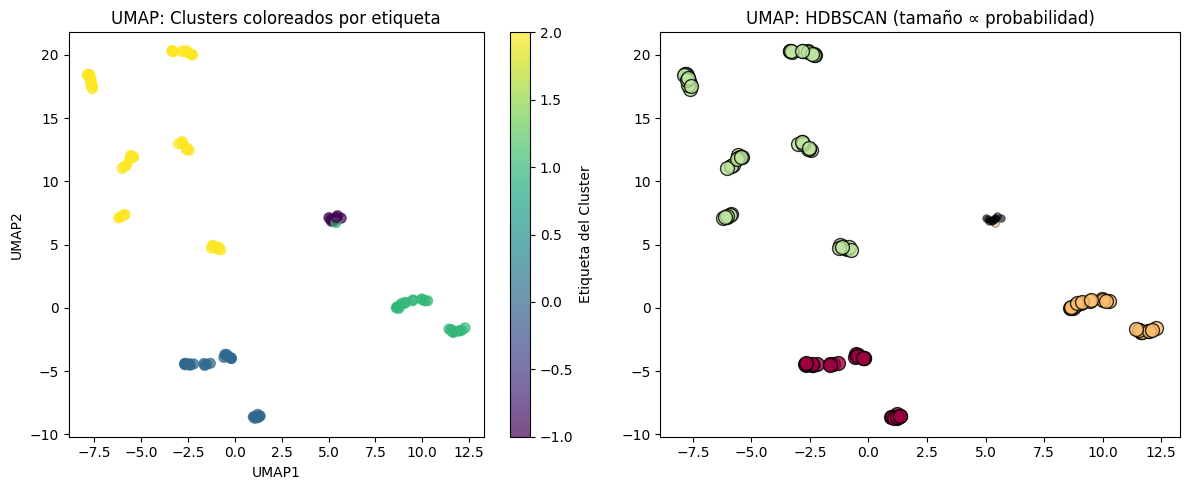

In [71]:
plot_umap_hdbscan(df_comorbilidades_grupo_6, min_cluster_size)

In [72]:
# Paciente con covid-19, hipertension, enf. renal y respiratoria
df_comorbilidades_grupo_7 = df_comorbilidades[(df_comorbilidades['HIPER_ART/ART_HYPER'] == 1) &
(df_comorbilidades['DIABETES/DIABETES'] == 1) &
(df_comorbilidades['ENF_CARDIO/CARDIO_DISEASE'] == 0) &
(df_comorbilidades['ENF_RENAL/KIDNEY_DISEASE'] == 0) &
(df_comorbilidades['ENF_RESPIRA/RESPI_DISEASE'] == 0) &
(df_comorbilidades['OBESITIDAD/OBESITY'] == 0) &
(df_comorbilidades['CANCER/CANCER'] == 0) &
(df_comorbilidades['INMUNO/IMMUNO'] == 0) &
(df_comorbilidades['ENF_HEPATICA/LIVER_DISEASE'] == 0) &
(df_comorbilidades['VIH/SIDA'] == 0) &
(df_comorbilidades['TUBERCULOSIS/TUBERCULOSIS'] == 0) &
(df_comorbilidades['TRAST_NEURO/NEURO_DISORDERS'] == 0) &
(df_comorbilidades['TRAST_CEL_FALCI/SICKLE_CELL_DIS'] == 0) &
(df_comorbilidades['TABAQUISMO/SMOKING'] == 0)]

In [73]:
df_comorbilidades_grupo_7.describe()

,PATIENT ID,EDAD/AGE,SEXO/SEX,UCI_DIAS/ICU_DAYS,HIPER_ART/ART_HYPER,DIABETES/DIABETES,ENF_CARDIO/CARDIO_DISEASE,ENF_RENAL/KIDNEY_DISEASE,ENF_RESPIRA/RESPI_DISEASE,OBESITIDAD/OBESITY,CANCER/CANCER,INMUNO/IMMUNO,ENF_HEPATICA/LIVER_DISEASE,VIH/SIDA,TUBERCULOSIS/TUBERCULOSIS,TRAST_NEURO/NEURO_DISORDERS,TRAST_CEL_FALCI/SICKLE_CELL_DIS,TABAQUISMO/SMOKING
count,104.000000,104.000000,104.000000,104.0,104.0,104.0,104.0,104.0,104.0,104.0,104.0,104.0,104.0,104.0,104.0,104.0,104.0,104.0
mean,1469.692308,74.442308,0.519231,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,655.690803,10.206439,0.502050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,135.000000,50.000000,0.000000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,989.000000,68.000000,0.000000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,1606.500000,75.000000,1.000000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,2072.000000,82.000000,1.000000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,2296.000000,94.000000,1.000000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Grupo 7: Pacientes con covid-19, hipertensión arterial y diabetes
- Media de edad: 82 años
- Rango de edad: 50 a 94 años
- media de días de hospitalización: 1
- Pacientes: 118

In [74]:
# criterio estadístico para el tamaño mínimo de los clusters
dataset_size = len(df_comorbilidades_grupo_7)
min_cluster_size = int(dataset_size * 0.02)
print(f"Minimum cluster size: {min_cluster_size}")

Minimum cluster size: 2


c:\Users\Usuario\anaconda3\envs\reto10_pyg\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


104
Número de clusters encontrados: 3
Número de puntos de anomalías: 0


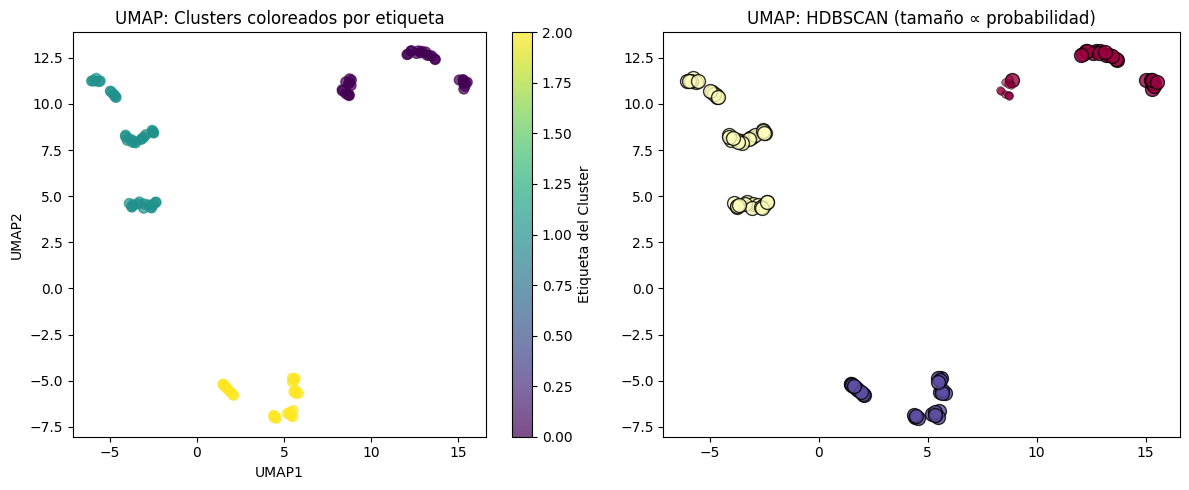

In [75]:
plot_umap_hdbscan(df_comorbilidades_grupo_7, min_cluster_size)

In [76]:
# Paciente con covid-19, diabetes y enf. respiratoria
df_comorbilidades_grupo_8 = df_comorbilidades[(df_comorbilidades['HIPER_ART/ART_HYPER'] == 0) &
(df_comorbilidades['DIABETES/DIABETES'] == 1) &
(df_comorbilidades['ENF_CARDIO/CARDIO_DISEASE'] == 0) &
(df_comorbilidades['ENF_RENAL/KIDNEY_DISEASE'] == 0) &
(df_comorbilidades['ENF_RESPIRA/RESPI_DISEASE'] == 1) &
(df_comorbilidades['OBESITIDAD/OBESITY'] == 0) &
(df_comorbilidades['CANCER/CANCER'] == 0) &
(df_comorbilidades['INMUNO/IMMUNO'] == 0) &
(df_comorbilidades['ENF_HEPATICA/LIVER_DISEASE'] == 0) &
(df_comorbilidades['VIH/SIDA'] == 0) &
(df_comorbilidades['TUBERCULOSIS/TUBERCULOSIS'] == 0) &
(df_comorbilidades['TRAST_NEURO/NEURO_DISORDERS'] == 0) &
(df_comorbilidades['TRAST_CEL_FALCI/SICKLE_CELL_DIS'] == 0) &
(df_comorbilidades['TABAQUISMO/SMOKING'] == 0)]

In [77]:
df_comorbilidades_grupo_8.describe()

,PATIENT ID,EDAD/AGE,SEXO/SEX,UCI_DIAS/ICU_DAYS,HIPER_ART/ART_HYPER,DIABETES/DIABETES,ENF_CARDIO/CARDIO_DISEASE,ENF_RENAL/KIDNEY_DISEASE,ENF_RESPIRA/RESPI_DISEASE,OBESITIDAD/OBESITY,CANCER/CANCER,INMUNO/IMMUNO,ENF_HEPATICA/LIVER_DISEASE,VIH/SIDA,TUBERCULOSIS/TUBERCULOSIS,TRAST_NEURO/NEURO_DISORDERS,TRAST_CEL_FALCI/SICKLE_CELL_DIS,TABAQUISMO/SMOKING
count,92.000000,92.000000,92.000000,92.000000,92.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0
mean,1193.652174,70.195652,0.565217,1.347826,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,639.264626,14.870311,0.498445,1.425319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,78.000000,39.000000,0.000000,1.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,645.000000,55.000000,0.000000,1.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,1265.500000,72.000000,1.000000,1.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1744.000000,85.000000,1.000000,1.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,2192.000000,91.000000,1.000000,10.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Grupo 8: Pacientes con covid-19, diabetes y enfermedad respiratoria crónica
- Media de edad: 70 años
- Rango de edad: 39 a 91 años
- media de días de hospitalización: 1.34
- Pacientes: 92

In [78]:
# criterio estadístico para el tamaño mínimo de los clusters
dataset_size = len(df_comorbilidades_grupo_8)
min_cluster_size = int(dataset_size * 0.02)
print(f"Minimum cluster size: {min_cluster_size}")

Minimum cluster size: 1


c:\Users\Usuario\anaconda3\envs\reto10_pyg\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


92
Número de clusters encontrados: 2
Número de puntos de anomalías: 59


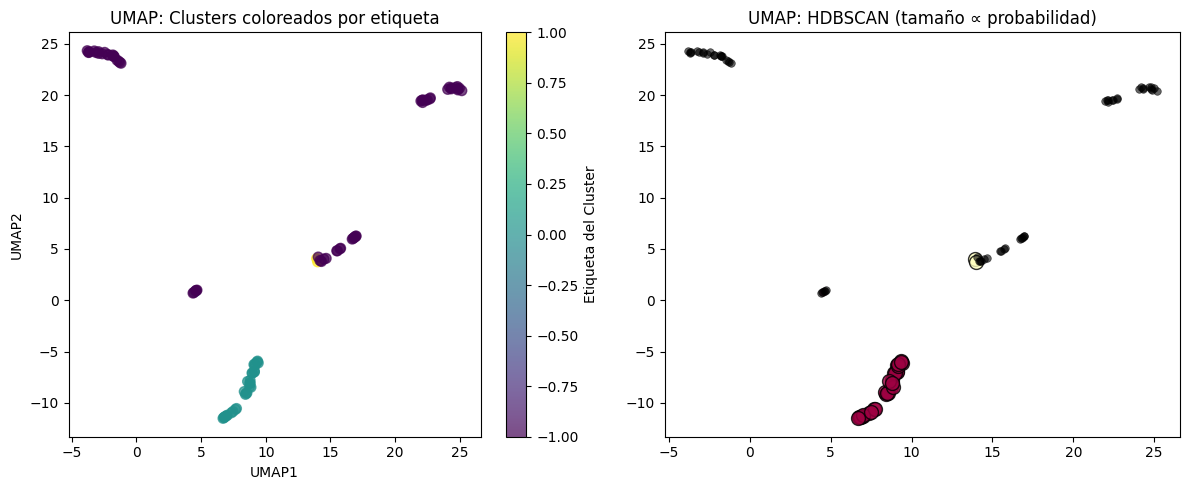

In [83]:
plot_umap_hdbscan(df_comorbilidades_grupo_8, min_cluster_size)

In [84]:
# Paciente con covid-19 y diabetes
df_comorbilidades_grupo_9 = df_comorbilidades[(df_comorbilidades['HIPER_ART/ART_HYPER'] == 0) &
(df_comorbilidades['DIABETES/DIABETES'] == 1) &
(df_comorbilidades['ENF_CARDIO/CARDIO_DISEASE'] == 0) &
(df_comorbilidades['ENF_RENAL/KIDNEY_DISEASE'] == 0) &
(df_comorbilidades['ENF_RESPIRA/RESPI_DISEASE'] == 0) &
(df_comorbilidades['OBESITIDAD/OBESITY'] == 0) &
(df_comorbilidades['CANCER/CANCER'] == 0) &
(df_comorbilidades['INMUNO/IMMUNO'] == 0) &
(df_comorbilidades['ENF_HEPATICA/LIVER_DISEASE'] == 0) &
(df_comorbilidades['VIH/SIDA'] == 0) &
(df_comorbilidades['TUBERCULOSIS/TUBERCULOSIS'] == 0) &
(df_comorbilidades['TRAST_NEURO/NEURO_DISORDERS'] == 0) &
(df_comorbilidades['TRAST_CEL_FALCI/SICKLE_CELL_DIS'] == 0) &
(df_comorbilidades['TABAQUISMO/SMOKING'] == 0)]

In [85]:
df_comorbilidades_grupo_9.describe()

,PATIENT ID,EDAD/AGE,SEXO/SEX,UCI_DIAS/ICU_DAYS,HIPER_ART/ART_HYPER,DIABETES/DIABETES,ENF_CARDIO/CARDIO_DISEASE,ENF_RENAL/KIDNEY_DISEASE,ENF_RESPIRA/RESPI_DISEASE,OBESITIDAD/OBESITY,CANCER/CANCER,INMUNO/IMMUNO,ENF_HEPATICA/LIVER_DISEASE,VIH/SIDA,TUBERCULOSIS/TUBERCULOSIS,TRAST_NEURO/NEURO_DISORDERS,TRAST_CEL_FALCI/SICKLE_CELL_DIS,TABAQUISMO/SMOKING
count,70.000000,70.000000,70.000000,70.000000,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0
mean,1155.342857,68.285714,0.657143,1.571429,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,670.770137,14.106369,0.478091,3.356030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,58.000000,39.000000,0.000000,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,619.500000,58.750000,0.000000,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,1026.000000,71.000000,1.000000,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1703.500000,79.750000,1.000000,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,2233.000000,88.000000,1.000000,21.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Grupo 9: Pacientes con covid-19 y diabetes
- Media de edad: 68 años
- Rango de edad: 39 a 88 años
- media de días de hospitalización: 1.57
- Pacientes: 70

In [86]:
# criterio estadístico para el tamaño mínimo de los clusters
dataset_size = len(df_comorbilidades_grupo_9)
min_cluster_size = int(dataset_size * 0.02)
print(f"Minimum cluster size: {min_cluster_size}")

Minimum cluster size: 1


c:\Users\Usuario\anaconda3\envs\reto10_pyg\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


70
Número de clusters encontrados: 2
Número de puntos de anomalías: 10


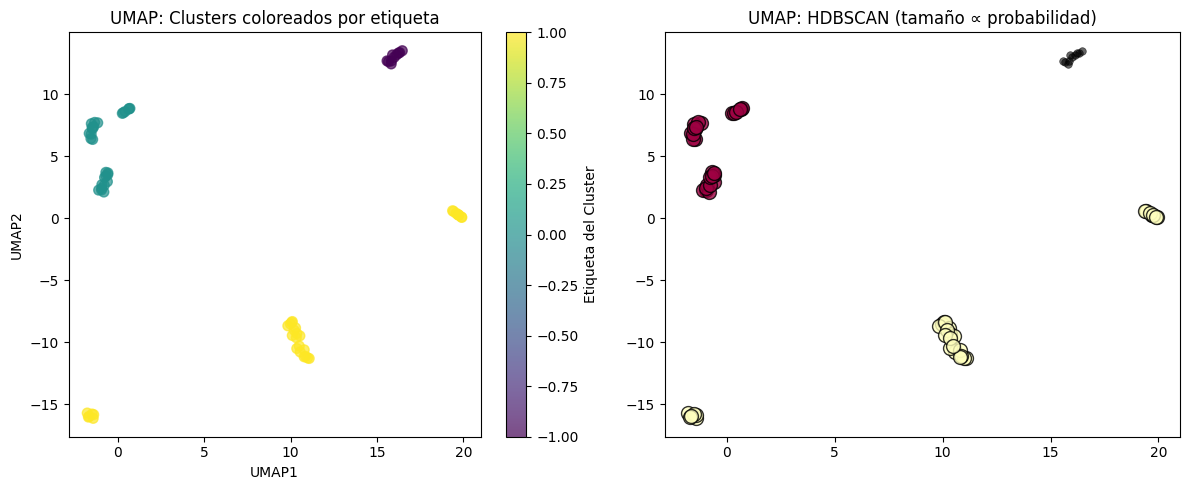

In [87]:
plot_umap_hdbscan(df_comorbilidades_grupo_9, min_cluster_size)

In [88]:
# Paciente con covid-19, enf. renal y respiratoria
df_comorbilidades_grupo_10 = df_comorbilidades[(df_comorbilidades['HIPER_ART/ART_HYPER'] == 0) &
(df_comorbilidades['DIABETES/DIABETES'] == 0) &
(df_comorbilidades['ENF_CARDIO/CARDIO_DISEASE'] == 0) &
(df_comorbilidades['ENF_RENAL/KIDNEY_DISEASE'] == 1) &
(df_comorbilidades['ENF_RESPIRA/RESPI_DISEASE'] == 1) &
(df_comorbilidades['OBESITIDAD/OBESITY'] == 0) &
(df_comorbilidades['CANCER/CANCER'] == 0) &
(df_comorbilidades['INMUNO/IMMUNO'] == 0) &
(df_comorbilidades['ENF_HEPATICA/LIVER_DISEASE'] == 0) &
(df_comorbilidades['VIH/SIDA'] == 0) &
(df_comorbilidades['TUBERCULOSIS/TUBERCULOSIS'] == 0) &
(df_comorbilidades['TRAST_NEURO/NEURO_DISORDERS'] == 0) &
(df_comorbilidades['TRAST_CEL_FALCI/SICKLE_CELL_DIS'] == 0) &
(df_comorbilidades['TABAQUISMO/SMOKING'] == 0)]

In [89]:
df_comorbilidades_grupo_10.describe()

,PATIENT ID,EDAD/AGE,SEXO/SEX,UCI_DIAS/ICU_DAYS,HIPER_ART/ART_HYPER,DIABETES/DIABETES,ENF_CARDIO/CARDIO_DISEASE,ENF_RENAL/KIDNEY_DISEASE,ENF_RESPIRA/RESPI_DISEASE,OBESITIDAD/OBESITY,CANCER/CANCER,INMUNO/IMMUNO,ENF_HEPATICA/LIVER_DISEASE,VIH/SIDA,TUBERCULOSIS/TUBERCULOSIS,TRAST_NEURO/NEURO_DISORDERS,TRAST_CEL_FALCI/SICKLE_CELL_DIS,TABAQUISMO/SMOKING
count,66.000000,66.000000,66.000000,66.000000,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0
mean,1374.666667,78.303030,0.575758,2.454545,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,602.266522,12.972124,0.498015,3.646629,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,101.000000,50.000000,0.000000,1.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,1167.000000,71.000000,0.000000,1.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,1578.000000,79.000000,1.000000,1.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1746.000000,88.000000,1.000000,1.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,2265.000000,106.000000,1.000000,17.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Grupo 10: Pacientes con covid-19, enfermedad renal crónica y enfermedad respiratoria crónica
- Media de edad: 78 años
- Rango de edad: 50 a 106 años
- media de días de hospitalización: 2.45
- Pacientes: 66

In [90]:
# criterio estadístico para el tamaño mínimo de los clusters
dataset_size = len(df_comorbilidades_grupo_10)
min_cluster_size = int(dataset_size * 0.02)
print(f"Minimum cluster size: {min_cluster_size}")

Minimum cluster size: 1


c:\Users\Usuario\anaconda3\envs\reto10_pyg\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


66
Número de clusters encontrados: 2
Número de puntos de anomalías: 0


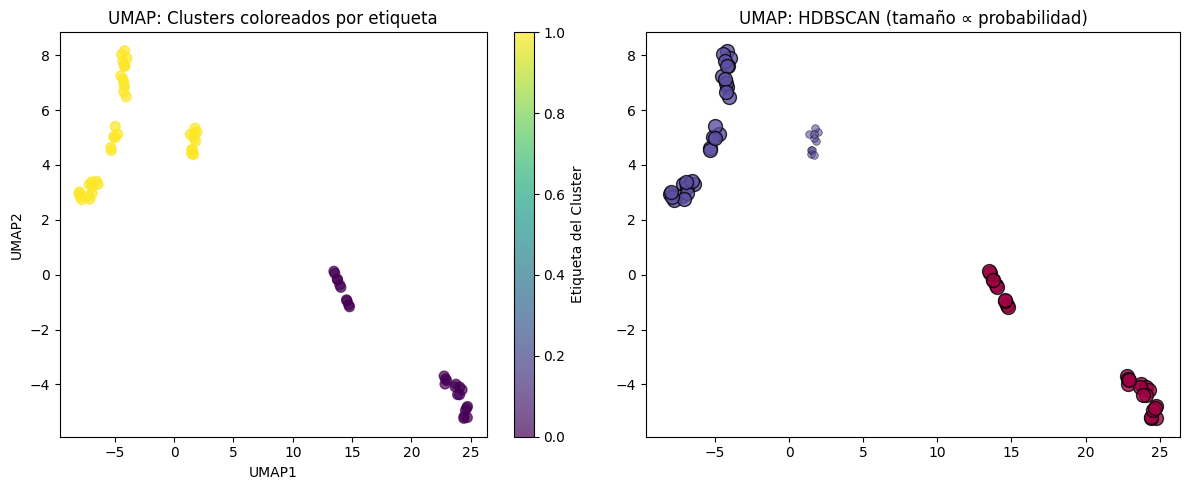

In [91]:
plot_umap_hdbscan(df_comorbilidades_grupo_10, min_cluster_size)

# Patrones farmacológicos por edad

In [339]:
df_farma = df.copy()
df_farma = df_farma[['EDAD/AGE', 'FARMACO/DRUG_NOMBRE_COMERCIAL/COMERCIAL_NAME']]
df_farma['EDAD/AGE'] = pd.to_numeric(df_farma['EDAD/AGE'], errors='coerce').fillna(0).astype(int)
df_farma['EDAD/AGE'] = df_farma['EDAD/AGE'].replace(0, round(df_farma['EDAD/AGE'].mean()))

In [340]:
# Relación entre dos variables categóricas
tabla = pd.crosstab(df_farma['EDAD/AGE'], df_farma['FARMACO/DRUG_NOMBRE_COMERCIAL/COMERCIAL_NAME'])
# agrupar por FARMACO/DRUG_NOMBRE_COMERCIAL/COMERCIAL_NAME y EDAD/AGE
tabla = df_farma.groupby(['FARMACO/DRUG_NOMBRE_COMERCIAL/COMERCIAL_NAME', 'EDAD/AGE']).size().reset_index(name='counts')
# ordenar por EDAD/AGE y counts
tabla = tabla.sort_values(by=['EDAD/AGE', 'counts'], ascending=[True, False])
# mostrar los valores máximos de cada EDAD/AGE
tabla_max = tabla.loc[tabla.groupby('EDAD/AGE')['counts'].idxmax()]

Tabla de frecuencias de FARMACO/DRUG_NOMBRE_COMERCIAL/COMERCIAL_NAME por EDAD/AGE:


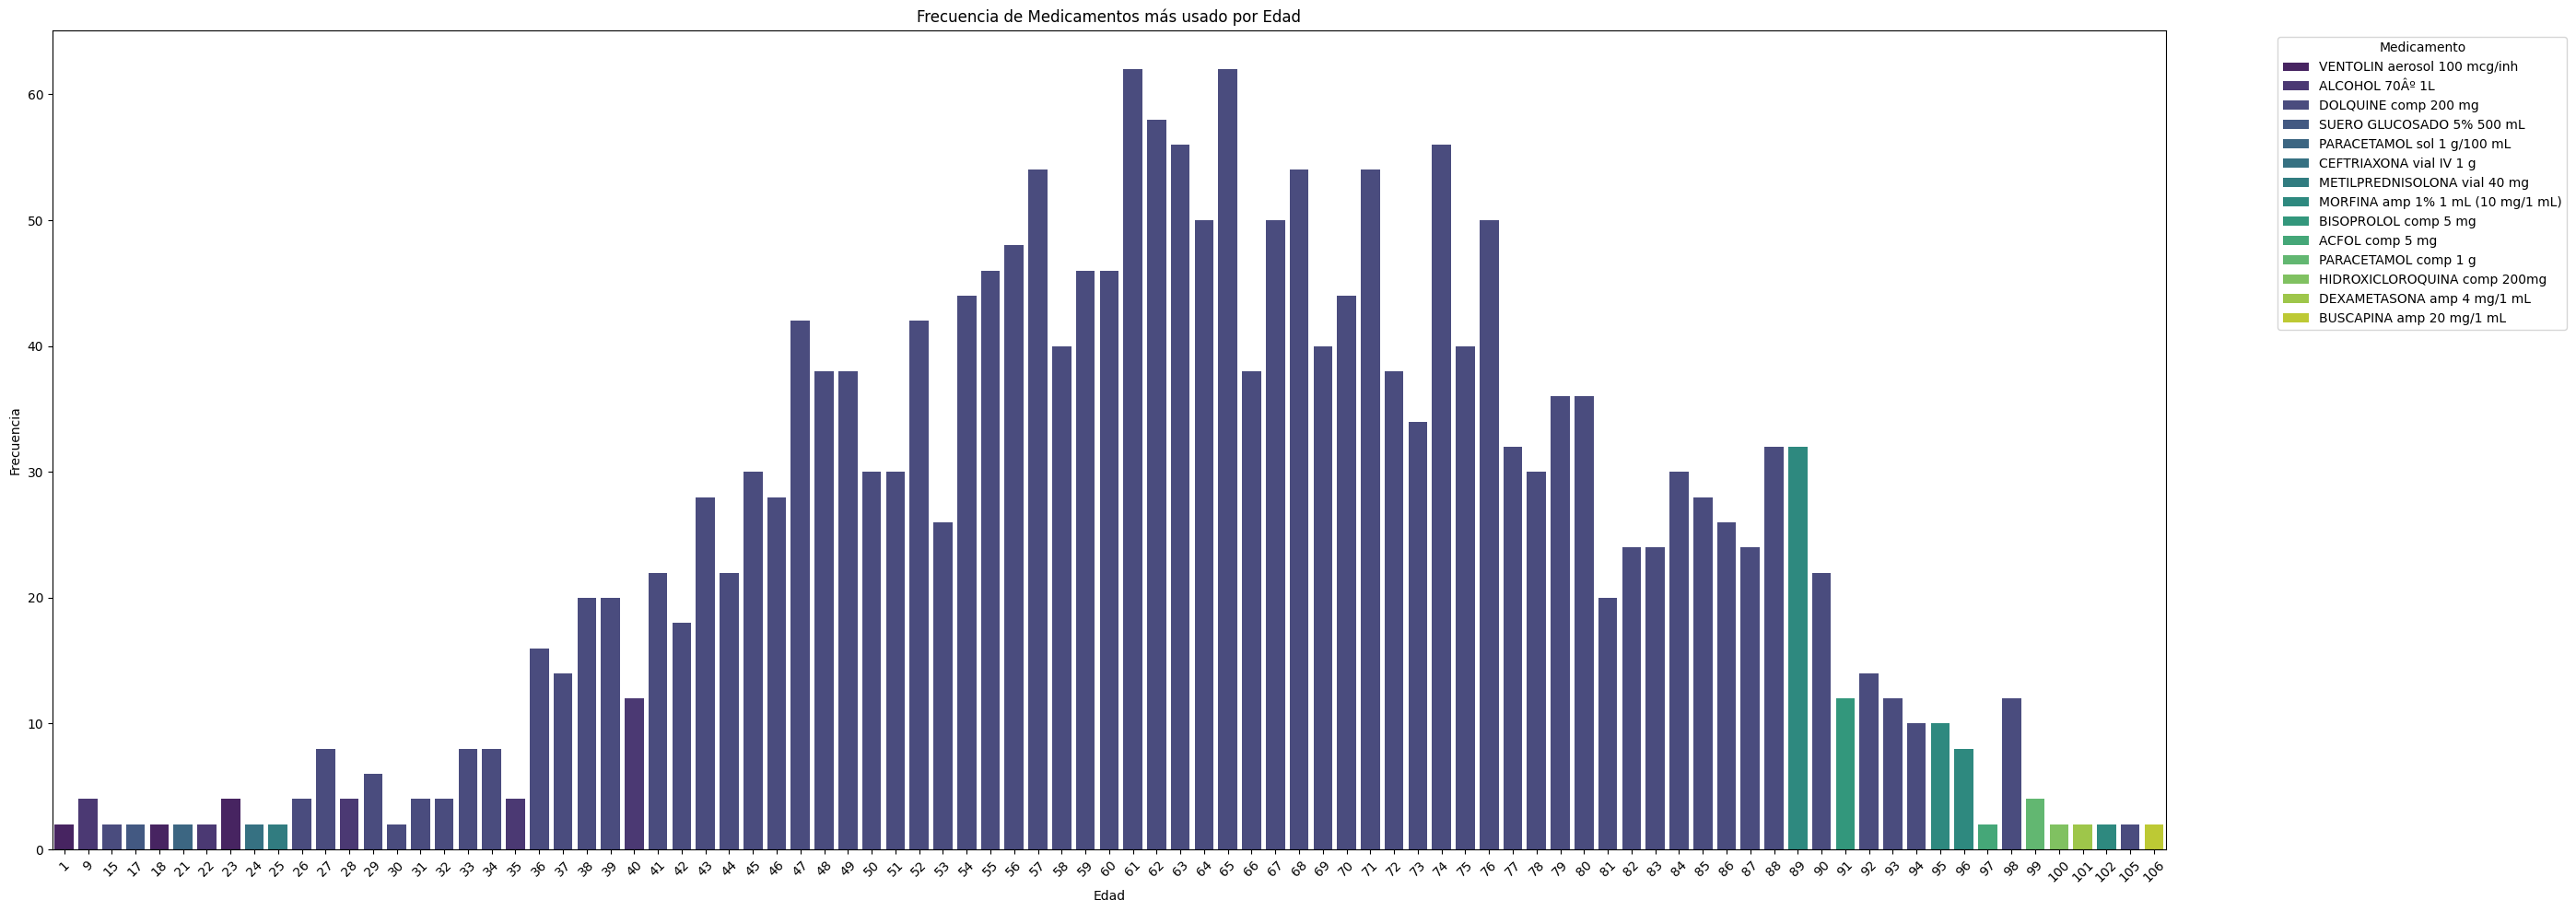

In [341]:
import seaborn as sns 
print("Tabla de frecuencias de FARMACO/DRUG_NOMBRE_COMERCIAL/COMERCIAL_NAME por EDAD/AGE:")
plt.figure(figsize=(28, 10))  # Tamaño grande y manejable
ax = sns.barplot(x='EDAD/AGE', y='counts', hue='FARMACO/DRUG_NOMBRE_COMERCIAL/COMERCIAL_NAME', data=tabla_max, palette='viridis')
plt.title('Frecuencia de Medicamentos más usado por Edad')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.legend(title='Medicamento', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Evolución de las constantes

Métricas que no incluyen los casos de la UCI/ICU

In [371]:
df_const = df.copy()

In [ ]:
# filtrado de columnas que contienen información de las constantes de los pacientes
df_const = df_const[['TA_MIN_ING/INPAT', 'CONSTANTS_ING/INPAT_HORA/TIME', 'GLU/GLY_ING/INPAT', 'CONSTANTS_ING/INPAT_FECHA/DATE', 'TEMP_ING/INPAT', 'FC/HR_ING/INPAT', 'TA_MAX_ING/INPAT', 'SAT_02_ING/INPAT', 'DIAG ING/INPAT']]
df_const = df_const[df_const['DIAG ING/INPAT'].str.contains('COVID19', na=False, case=False)]
# drop DIAG ING/INPAT column
df_const = df_const.drop(columns=['DIAG ING/INPAT'])


In [373]:
df_const.dtypes

TA_MIN_ING/INPAT                  object
CONSTANTS_ING/INPAT_HORA/TIME     object
GLU/GLY_ING/INPAT                 object
CONSTANTS_ING/INPAT_FECHA/DATE    object
TEMP_ING/INPAT                    object
FC/HR_ING/INPAT                   object
TA_MAX_ING/INPAT                  object
SAT_02_ING/INPAT                  object
dtype: object

In [369]:
df_const

,TA_MIN_ING/INPAT,CONSTANTS_ING/INPAT_HORA/TIME,GLU/GLY_ING/INPAT,CONSTANTS_ING/INPAT_FECHA/DATE,TEMP_ING/INPAT,FC/HR_ING/INPAT,TA_MAX_ING/INPAT,SAT_02_ING/INPAT
0,75,15:37,0,2020-12-11,35.9,60,126,0
1,0,23:39,0,2020-04-19,36.2,74,0,0
2,60,12:42,0,2020-03-22,35.8,85,120,0
3,75,16:58,0,2020-03-16,37.4,87,130,0
4,0,00:35,0,2020-03-29,37.9,0,0,0
...,...,...,...,...,...,...,...,...
7842,0,17:18,0,2020-03-25,36.8,58,0,0
7843,0,18:13,0,2020-03-25,37.0,0,0,0
7844,0,16:31,0,2020-03-23,35.3,94,0,0
7845,0,17:28,0,2020-03-23,36.5,0,0,0


In [375]:
df_const.fillna(0, inplace=True)
# Convertir las columnas numéricas a tipo float
# Convertir las columnas a numéricas, forzando errores a NaN y luego rellenando con 0 antes de convertir a int/float
df_const['TA_MIN_ING/INPAT'] = pd.to_numeric(df_const['TA_MIN_ING/INPAT'], errors='coerce').fillna(0).astype(int)
df_const['GLU/GLY_ING/INPAT'] = pd.to_numeric(df_const['GLU/GLY_ING/INPAT'], errors='coerce').fillna(0).astype(int)
df_const['FC/HR_ING/INPAT'] = pd.to_numeric(df_const['FC/HR_ING/INPAT'], errors='coerce').fillna(0).astype(int)
df_const['TEMP_ING/INPAT'] = pd.to_numeric(df_const['TEMP_ING/INPAT'], errors='coerce').fillna(0).astype(float)
df_const['TA_MAX_ING/INPAT'] = pd.to_numeric(df_const['TA_MAX_ING/INPAT'], errors='coerce').fillna(0).astype(int)
df_const['SAT_02_ING/INPAT'] = pd.to_numeric(df_const['SAT_02_ING/INPAT'], errors='coerce').fillna(0).astype(int)
# imputar los valores 0 por la media de la columna
df_const['TA_MIN_ING/INPAT'] = df_const['TA_MIN_ING/INPAT'].replace(0, round(df_const['TA_MIN_ING/INPAT'].mean()))
df_const['GLU/GLY_ING/INPAT'] = df_const['GLU/GLY_ING/INPAT'].replace(0, round((df_const['GLU/GLY_ING/INPAT'].mean())))
df_const['TEMP_ING/INPAT'] = df_const['TEMP_ING/INPAT'].replace(0, round(df_const['TEMP_ING/INPAT'].mean()))
df_const['FC/HR_ING/INPAT'] = df_const['FC/HR_ING/INPAT'].replace(0, round(df_const['FC/HR_ING/INPAT'].mean()))
df_const['SAT_02_ING/INPAT'] = df_const['SAT_02_ING/INPAT'].replace(0, round(df_const['SAT_02_ING/INPAT'].mean()))
df_const['TA_MAX_ING/INPAT'] = df_const['TA_MAX_ING/INPAT'].replace(0, round(df_const['TA_MAX_ING/INPAT'].mean()))

In [376]:
# agrupar por 'CONSTANTS_ING/INPAT_FECHA/DATE' y calcular la media de las constantes
df_const_grouped = df_const.groupby('CONSTANTS_ING/INPAT_FECHA/DATE').aggregate({
    'TA_MIN_ING/INPAT': 'mean',
    'TA_MAX_ING/INPAT': 'mean',
    'TEMP_ING/INPAT': 'mean',
    'FC/HR_ING/INPAT': 'mean',
    'SAT_02_ING/INPAT': 'mean',
    'GLU/GLY_ING/INPAT': 'mean'
}).reset_index()
df_const_grouped

,CONSTANTS_ING/INPAT_FECHA/DATE,TA_MIN_ING/INPAT,TA_MAX_ING/INPAT,TEMP_ING/INPAT,FC/HR_ING/INPAT,SAT_02_ING/INPAT,GLU/GLY_ING/INPAT
0,2020-03-01,49.0,101.0,35.00,77.0,1.0,0.0
1,2020-03-03,60.0,110.0,36.10,56.0,1.0,0.0
2,2020-03-05,72.0,155.5,36.85,73.5,1.0,0.0
3,2020-03-06,36.0,63.0,37.30,63.0,1.0,0.0
4,2020-03-07,48.0,124.0,36.15,70.0,1.0,0.0
...,...,...,...,...,...,...,...
129,2021-02-04,54.5,89.5,35.20,69.5,1.0,0.0
130,2021-02-06,81.5,137.5,35.90,88.5,1.0,0.0
131,2021-02-09,93.0,175.0,36.30,75.0,1.0,0.0
132,2021-02-10,36.0,63.0,35.00,56.0,98.0,0.0


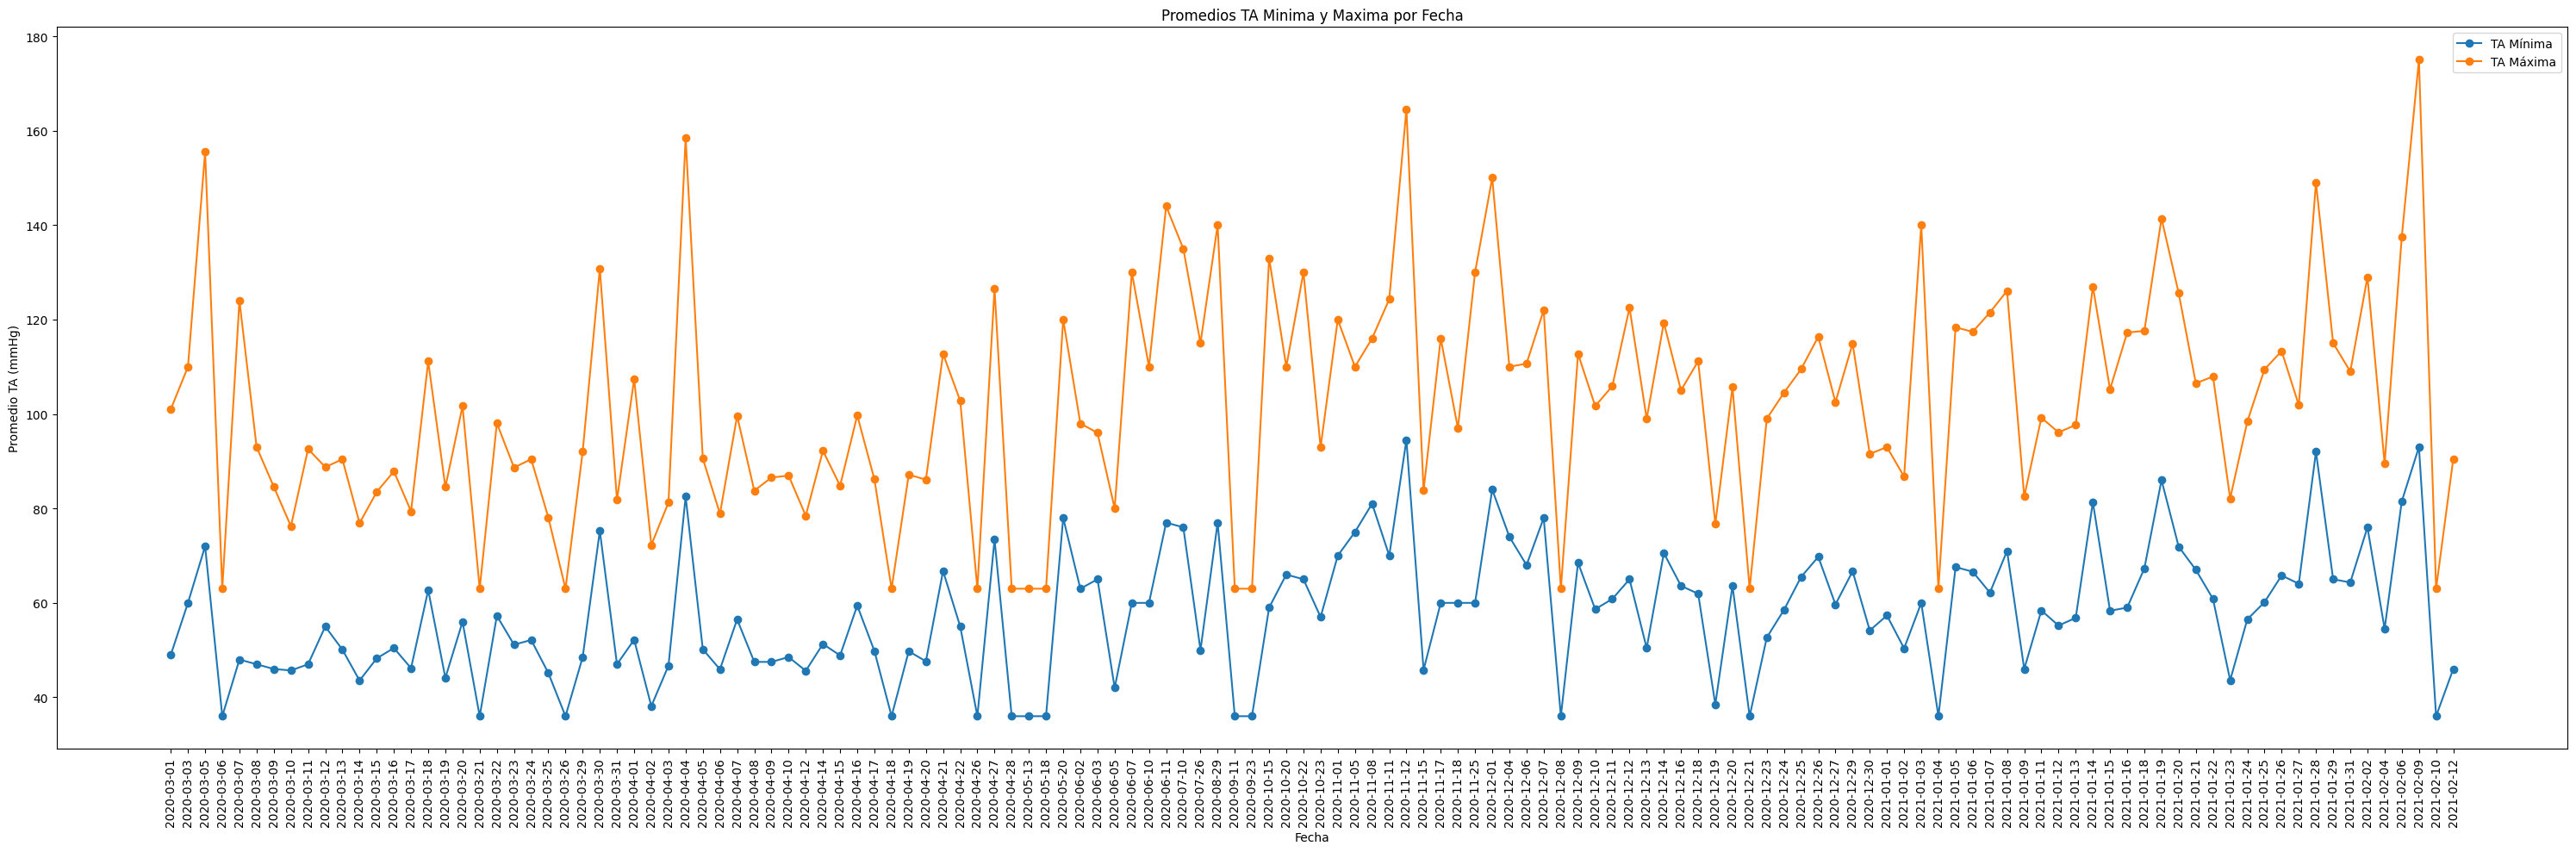

In [377]:
plt.figure(figsize=(30, 10))
plt.plot(df_const_grouped['CONSTANTS_ING/INPAT_FECHA/DATE'], df_const_grouped['TA_MIN_ING/INPAT'], label='TA Mínima', marker='o')
plt.plot(df_const_grouped['CONSTANTS_ING/INPAT_FECHA/DATE'], df_const_grouped['TA_MAX_ING/INPAT'], label='TA Máxima', marker='o')
plt.title('Promedios TA Minima y Maxima por Fecha')
plt.xlabel('Fecha')
plt.ylabel('Promedio TA (mmHg)')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

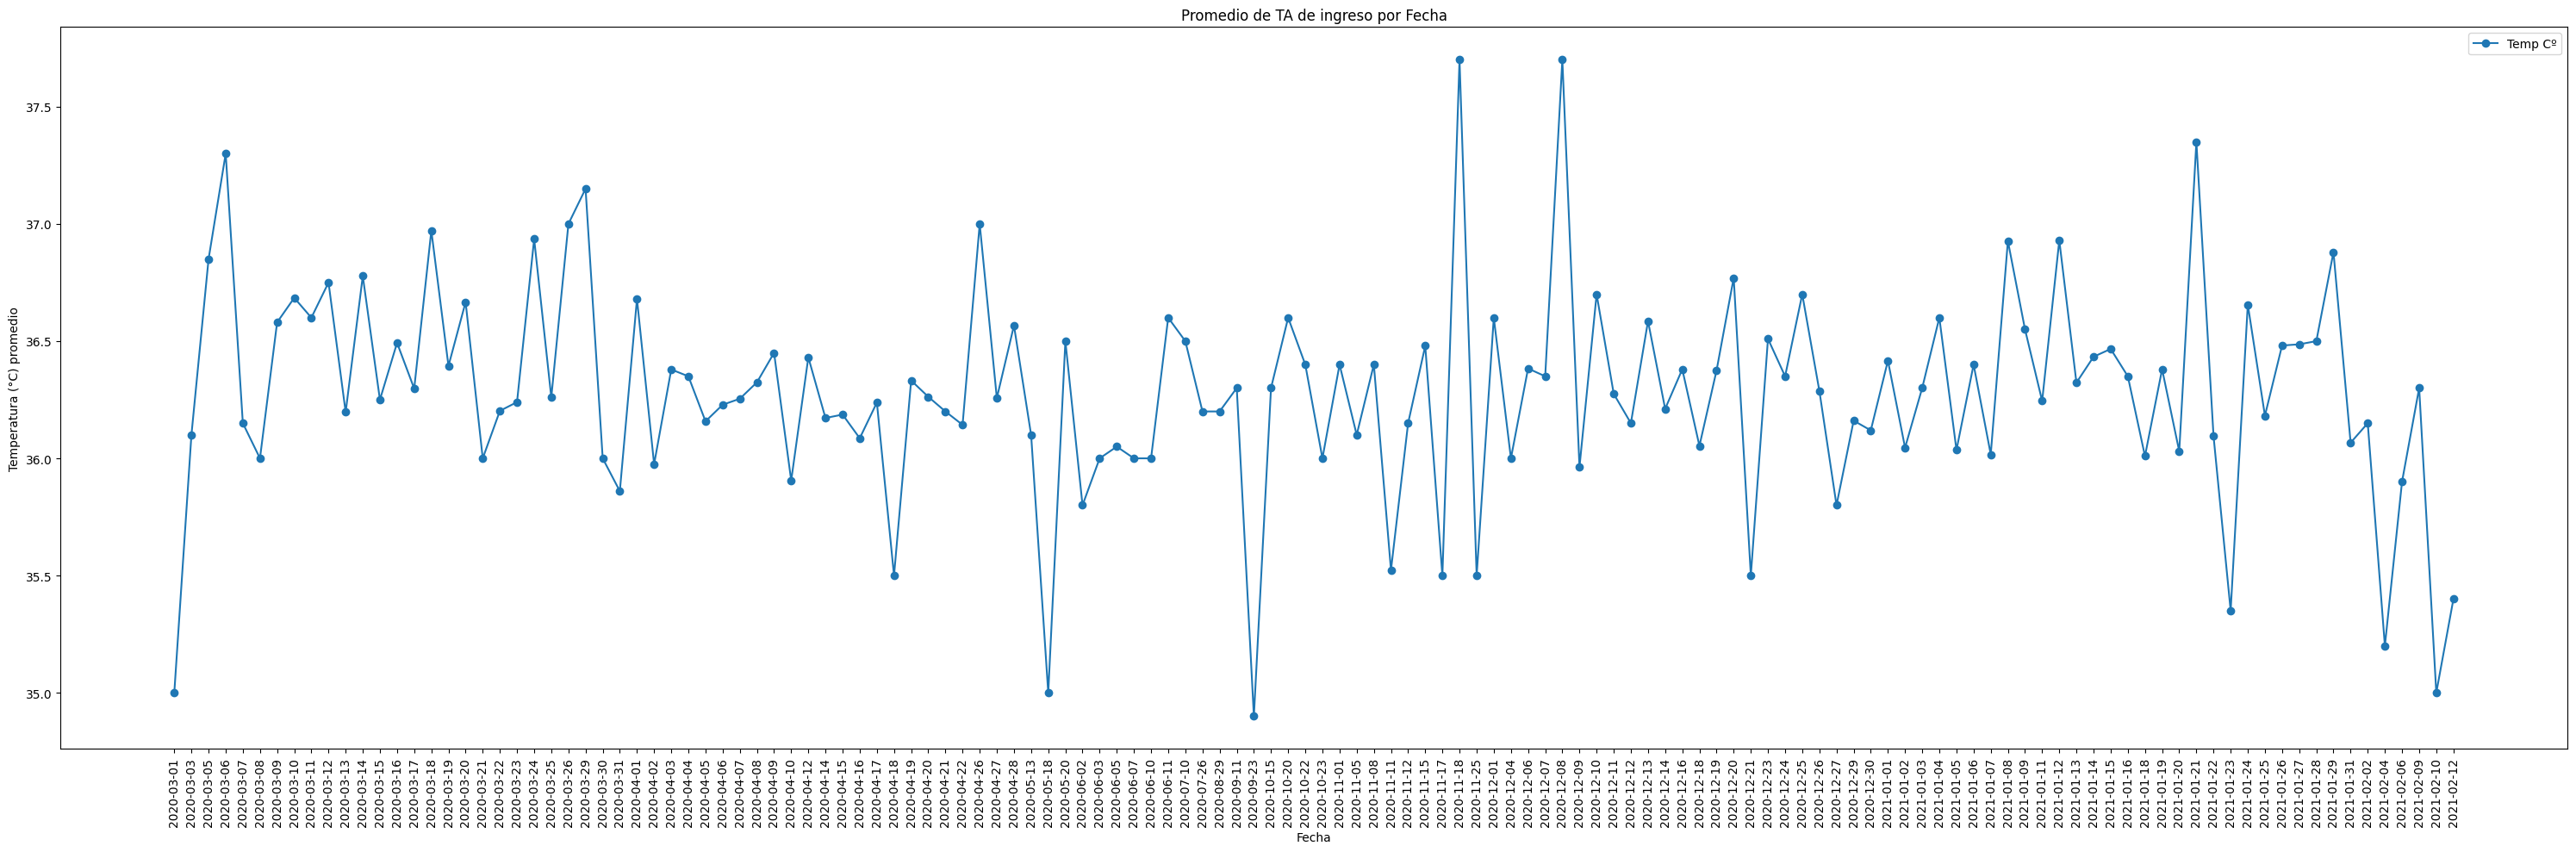

In [378]:
plt.figure(figsize=(30, 10))
plt.plot(df_const_grouped['CONSTANTS_ING/INPAT_FECHA/DATE'], df_const_grouped['TEMP_ING/INPAT'], label='Temp Cº', marker='o')
plt.title('Promedio de TA de ingreso por Fecha')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°C) promedio')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

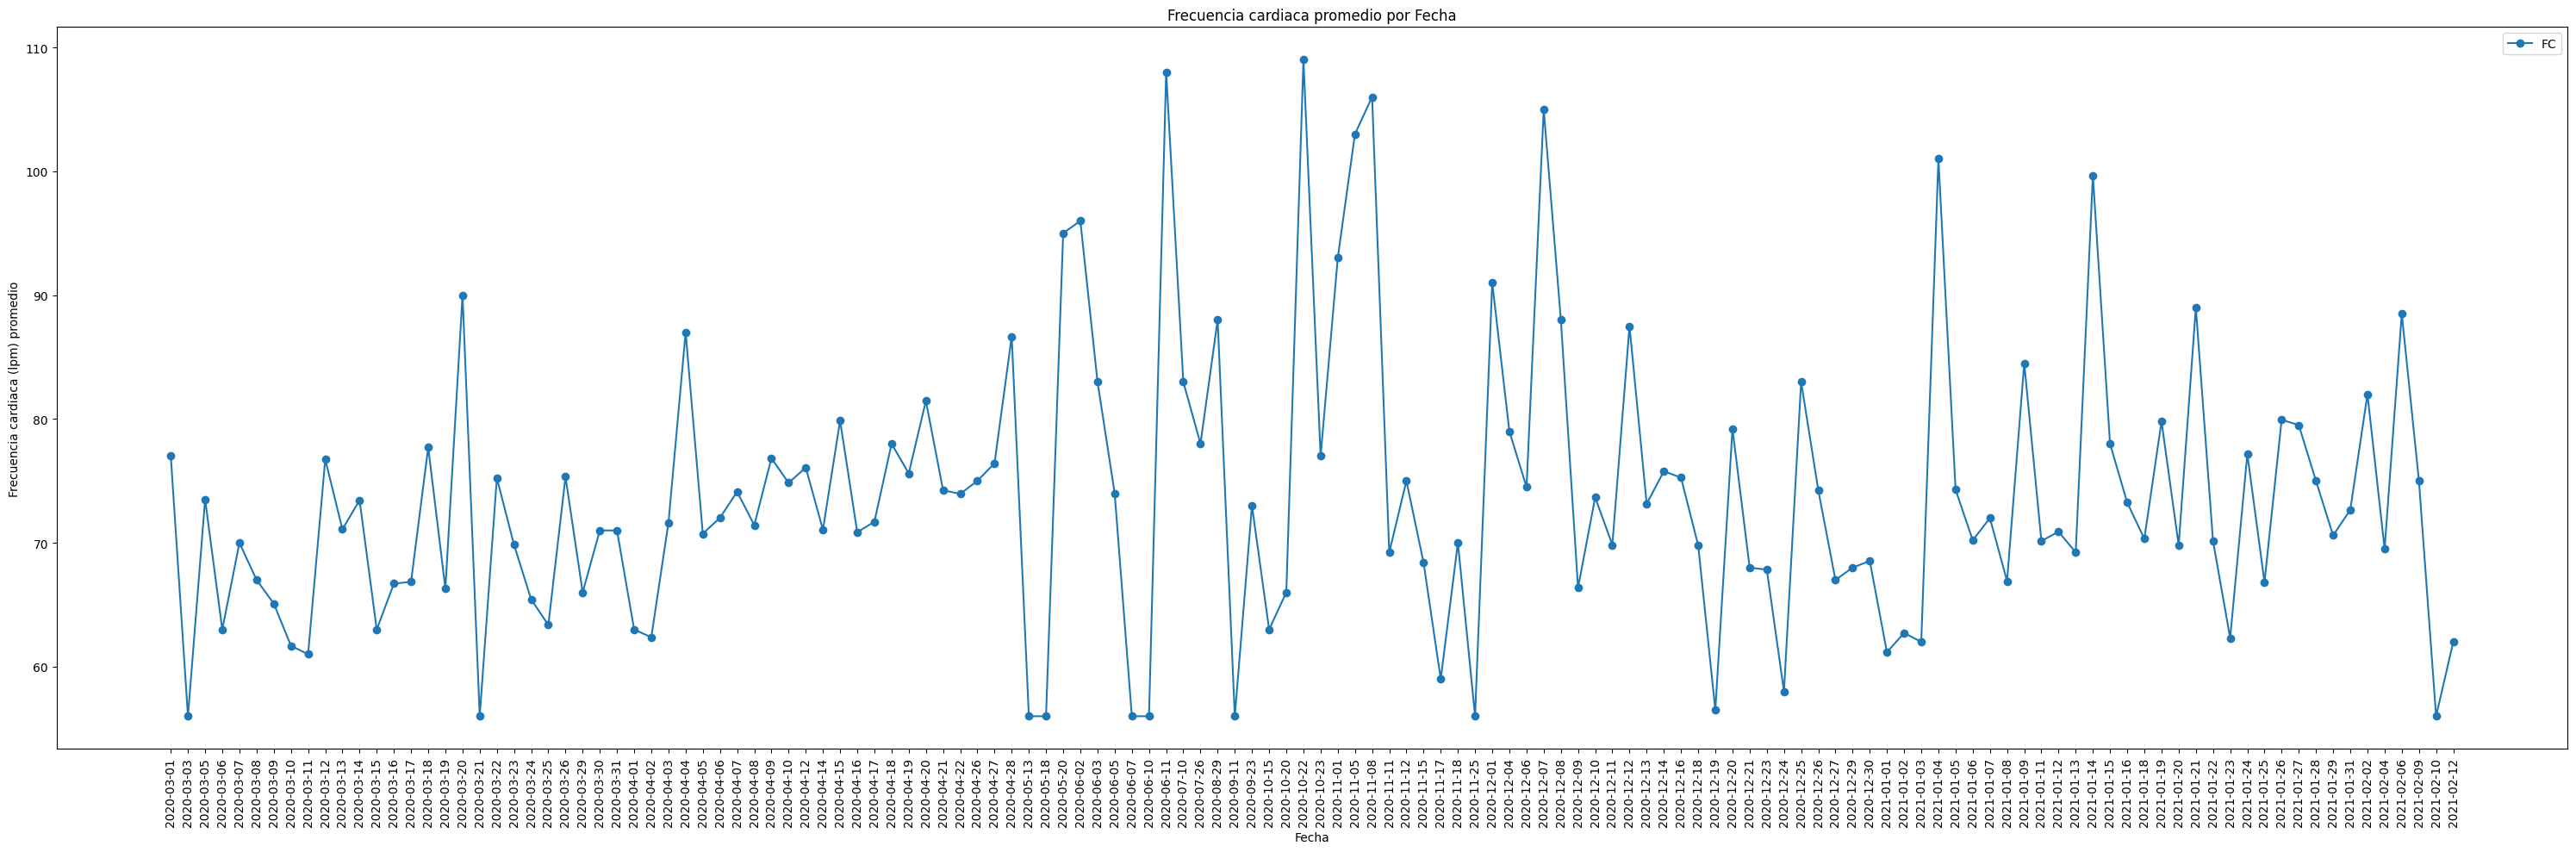

In [379]:
plt.figure(figsize=(30, 10))
plt.plot(df_const_grouped['CONSTANTS_ING/INPAT_FECHA/DATE'], df_const_grouped['FC/HR_ING/INPAT'], label='FC', marker='o')
plt.title('Frecuencia cardiaca promedio por Fecha')
plt.xlabel('Fecha')
plt.ylabel('Frecuencia cardiaca (lpm) promedio')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

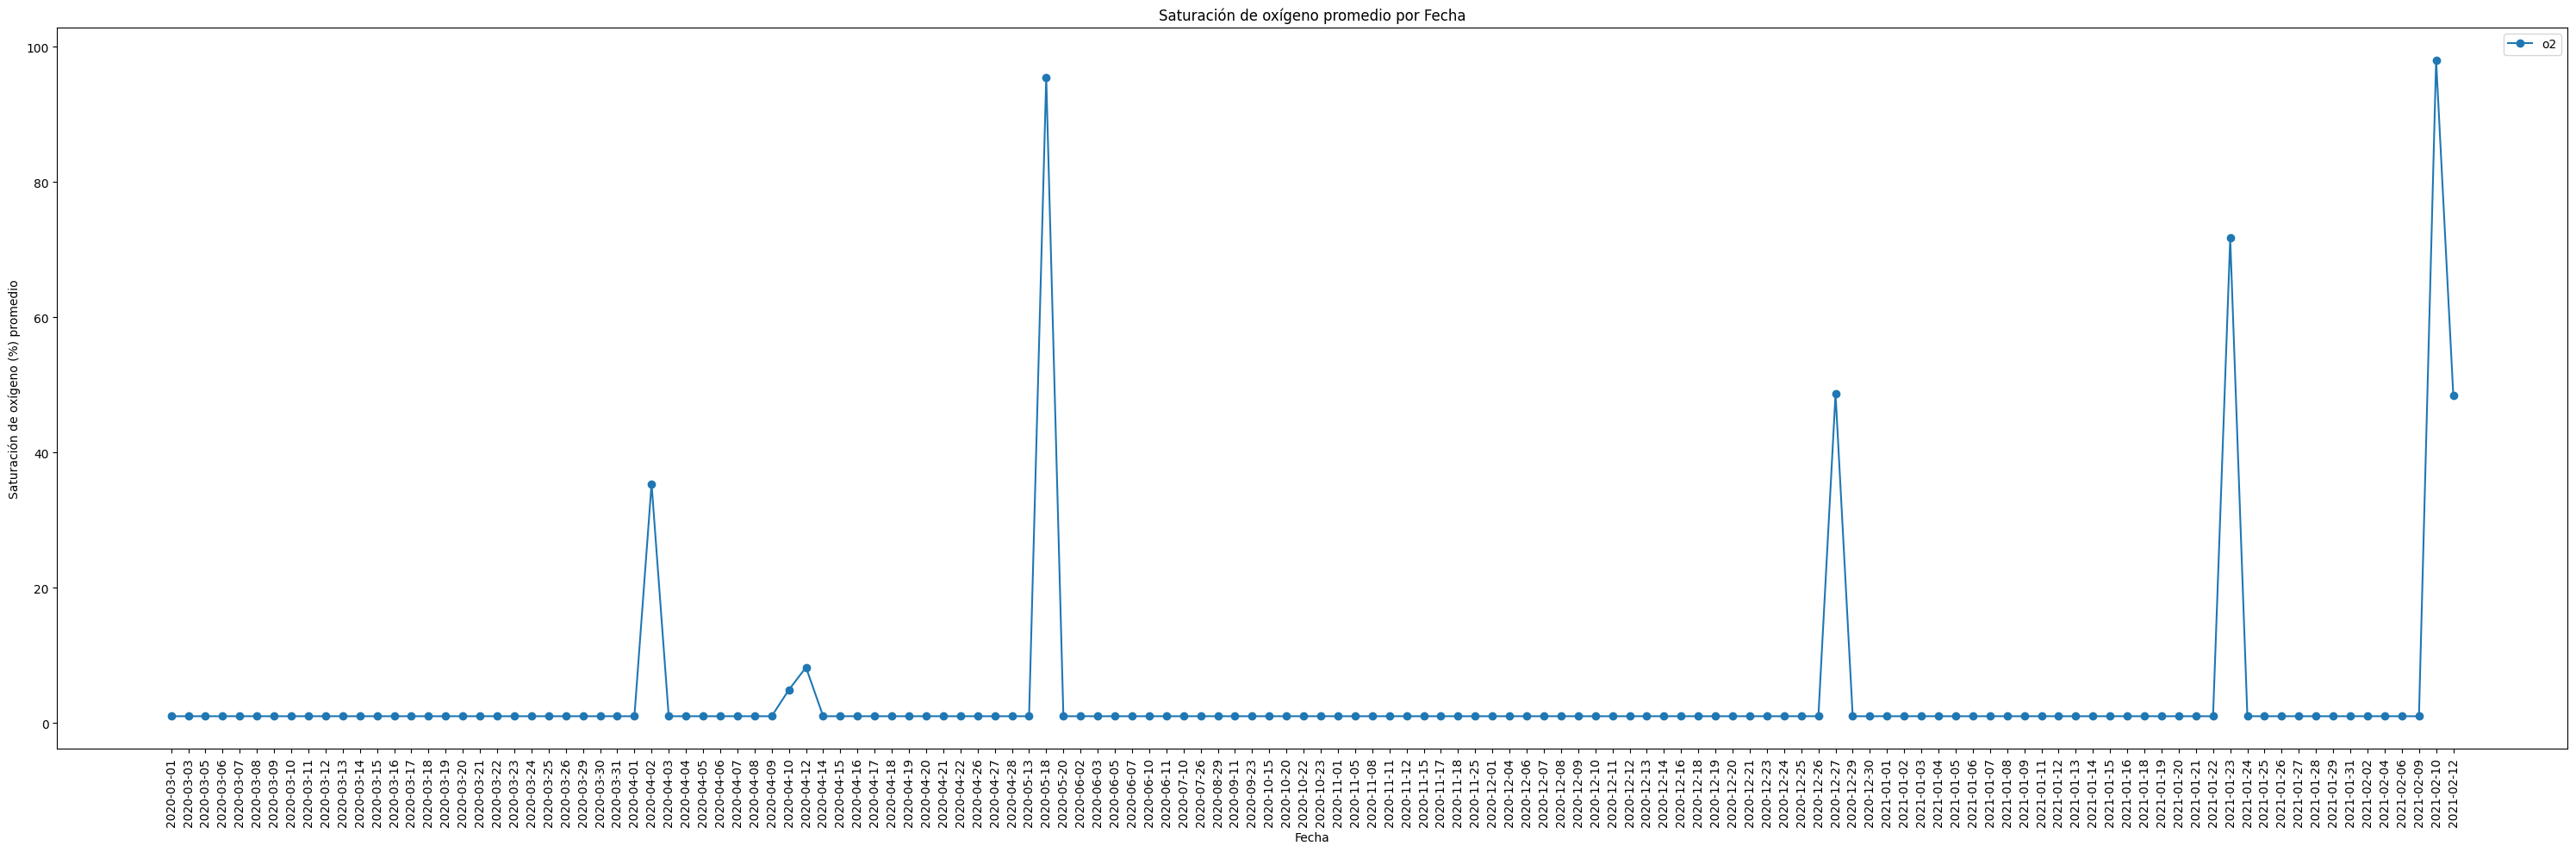

In [380]:
plt.figure(figsize=(30, 10))
plt.plot(df_const_grouped['CONSTANTS_ING/INPAT_FECHA/DATE'], df_const_grouped['SAT_02_ING/INPAT'], label='o2', marker='o')
plt.title('Saturación de oxígeno promedio por Fecha')
plt.xlabel('Fecha')
plt.ylabel('Saturación de oxígeno (%) promedio')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


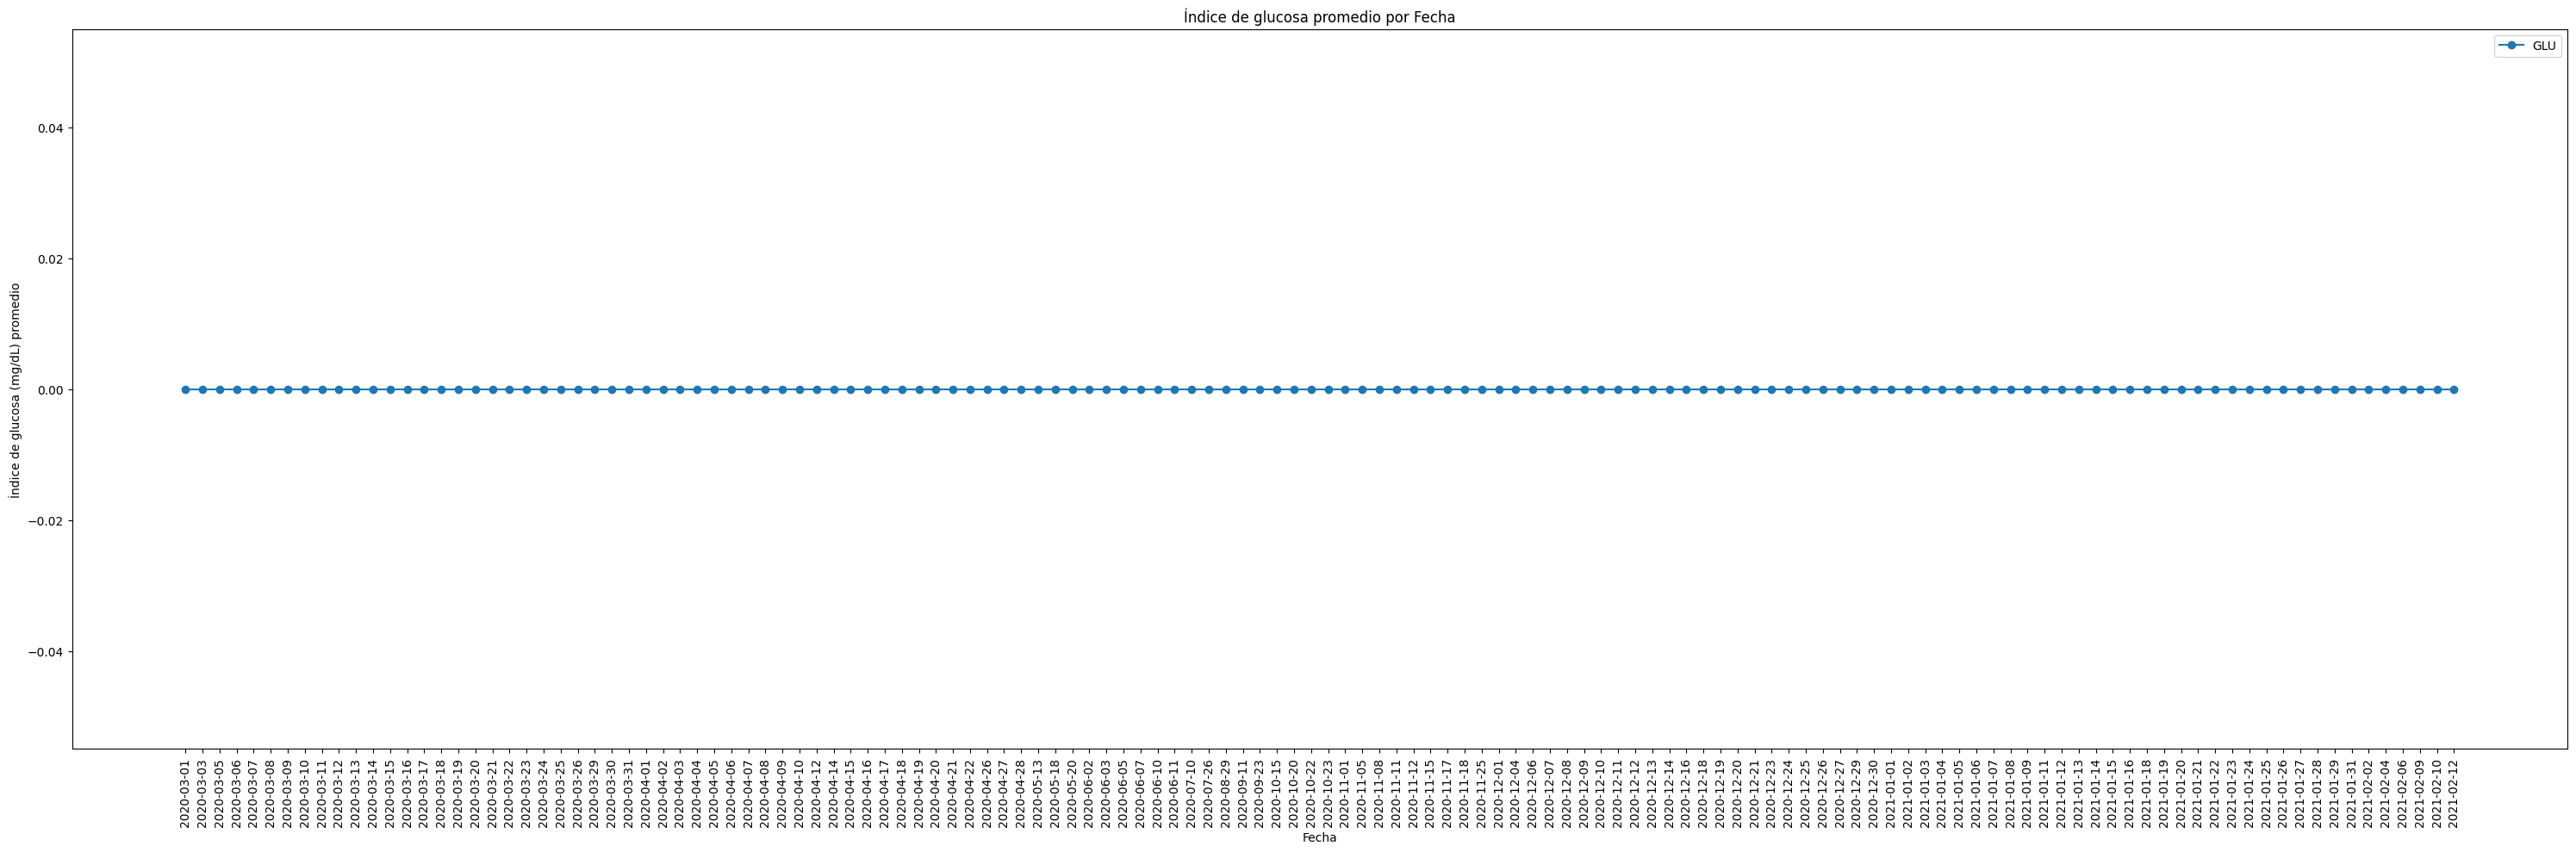

In [381]:
plt.figure(figsize=(30, 10))
plt.plot(df_const_grouped['CONSTANTS_ING/INPAT_FECHA/DATE'], df_const_grouped['GLU/GLY_ING/INPAT'], label='GLU', marker='o')
plt.title('Índice de glucosa promedio por Fecha')
plt.xlabel('Fecha')
plt.ylabel('Índice de glucosa (mg/dL) promedio')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


Métricas que se tomaron en urgencias y en UCI

In [396]:
df_const_uci = df[['TA_MIN_PRIMERA/FIRST_URG/EMERG',
                        'TA_MIN_ULTIMA/LAST_URG/EMERG',
                        'HORA/TIME_CONSTANT_PRIMERA/FIRST_URG/EMERG',
                        'HORA/TIME_CONSTANT_ULTIMA/LAST_URG/EMERG',
                        'GLU_PRIMERA/FIRST_URG/EMERG',
                        'GLU_ULTIMA/LAST_URG/EMERG',
                        'TEMP_PRIMERA/FIRST_URG/EMERG',
                        'TEMP_ULTIMA/LAST_URG/EMERG',
                        'FC/HR_PRIMERA/FIRST_URG/EMERG',
                        'FC/HR_ULTIMA/LAST_URG/EMERG',
                        'TA_MAX_PRIMERA/FIRST/EMERG_URG',
                        'TA_MAX_ULTIMA/LAST_URGEMERG',
                        'SAT_02_PRIMERA/FIRST_URG/EMERG',
                        'SAT_02_ULTIMA/LAST_URG/EMERG',
                        'F_INGRESO/ADMISSION_D_ING/INPAT',
                        'DIAG ING/INPAT'
                        ]]

In [397]:
df_const_uci.dtypes

TA_MIN_PRIMERA/FIRST_URG/EMERG                object
TA_MIN_ULTIMA/LAST_URG/EMERG                  object
HORA/TIME_CONSTANT_PRIMERA/FIRST_URG/EMERG    object
HORA/TIME_CONSTANT_ULTIMA/LAST_URG/EMERG      object
GLU_PRIMERA/FIRST_URG/EMERG                   object
GLU_ULTIMA/LAST_URG/EMERG                     object
TEMP_PRIMERA/FIRST_URG/EMERG                  object
TEMP_ULTIMA/LAST_URG/EMERG                    object
FC/HR_PRIMERA/FIRST_URG/EMERG                 object
FC/HR_ULTIMA/LAST_URG/EMERG                   object
TA_MAX_PRIMERA/FIRST/EMERG_URG                object
TA_MAX_ULTIMA/LAST_URGEMERG                   object
SAT_02_PRIMERA/FIRST_URG/EMERG                object
SAT_02_ULTIMA/LAST_URG/EMERG                  object
F_INGRESO/ADMISSION_D_ING/INPAT               object
DIAG ING/INPAT                                object
dtype: object

In [406]:
df_const_uci

,TA_MIN_PRIMERA/FIRST_URG/EMERG,TA_MIN_ULTIMA/LAST_URG/EMERG,HORA/TIME_CONSTANT_PRIMERA/FIRST_URG/EMERG,HORA/TIME_CONSTANT_ULTIMA/LAST_URG/EMERG,GLU_PRIMERA/FIRST_URG/EMERG,GLU_ULTIMA/LAST_URG/EMERG,TEMP_PRIMERA/FIRST_URG/EMERG,TEMP_ULTIMA/LAST_URG/EMERG,FC/HR_PRIMERA/FIRST_URG/EMERG,FC/HR_ULTIMA/LAST_URG/EMERG,TA_MAX_PRIMERA/FIRST/EMERG_URG,TA_MAX_ULTIMA/LAST_URGEMERG,SAT_02_PRIMERA/FIRST_URG/EMERG,SAT_02_ULTIMA/LAST_URG/EMERG,F_INGRESO/ADMISSION_D_ING/INPAT
0,75,0,0,0,60,35,0.0,0.0,75,0,60,35,126,1,28/01/2020
1,36,0,18:27:00,18:34:00,74,36,0.0,0.0,36,0,74,36,63,1,05/02/2020
2,60,0,15:35:00,18:54:00,85,35,37.1,37.0,60,0,85,35,120,1,06/02/2020
3,75,0,0:41:00,0:55:00,87,37,36.0,36.0,75,0,87,37,130,1,06/02/2020
4,36,0,0:46:00,0:57:00,56,37,37.8,37.8,36,0,56,37,63,1,24/02/2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6157,36,0,18:02:00,18:05:00,70,35,37.0,37.0,36,0,70,35,63,1,19/04/2020
6158,67,0,11:37:00,15:11:00,80,35,36.5,36.5,67,0,80,35,107,1,19/04/2020
6159,71,0,0:12:00,23:53:00,95,36,37.6,37.6,71,0,95,36,112,1,20/04/2020
6160,36,0,0,7:39:00,79,36,0.0,36.1,36,0,79,36,63,1,20/04/2020


In [398]:
df_const_uci = df_const_uci[df_const_uci['DIAG ING/INPAT'].str.contains('COVID19', na=False, case=False)]
# drop DIAG ING/INPAT column
df_const_uci = df_const_uci.drop(columns=['DIAG ING/INPAT'])
df_const_uci.fillna(0, inplace=True)
# sustituir los valores , por . en las columnas TEMP_PRIMERA/FIRST_URG/EMERG	TEMP_ULTIMA/LAST_URG/EMERG
df_const_uci.loc[:, 'TEMP_PRIMERA/FIRST_URG/EMERG'] = df_const_uci['TEMP_PRIMERA/FIRST_URG/EMERG'].str.replace(',', '.')
df_const_uci.loc[:, 'TEMP_ULTIMA/LAST_URG/EMERG'] = df_const_uci['TEMP_ULTIMA/LAST_URG/EMERG'].str.replace(',', '.')
# transformar TEMP_PRIMERA/FIRST_URG/EMERG	TEMP_ULTIMA/LAST_URG/EMERG de string a float con dos decimales
df_const_uci.loc[:, 'TEMP_PRIMERA/FIRST_URG/EMERG'] = df_const_uci['TEMP_PRIMERA/FIRST_URG/EMERG'].astype(float).round(2)
df_const_uci.loc[:, 'TEMP_ULTIMA/LAST_URG/EMERG'] = df_const_uci['TEMP_ULTIMA/LAST_URG/EMERG'].astype(float).round(2)
# Convertir las columnas a numéricas, forzando errores a NaN y luego rellenando con 0 antes de convertir a int/float

df_const_uci['TA_MIN_PRIMERA/FIRST_URG/EMERG'] = pd.to_numeric(df_const['TA_MIN_ING/INPAT'], errors='coerce').fillna(0).astype(int)
df_const_uci['TA_MIN_ULTIMA/LAST_URG/EMERG'] = pd.to_numeric(df_const['GLU/GLY_ING/INPAT'], errors='coerce').fillna(0).astype(int)
df_const_uci['GLU_PRIMERA/FIRST_URG/EMERG'] = pd.to_numeric(df_const['FC/HR_ING/INPAT'], errors='coerce').fillna(0).astype(int)
df_const_uci['GLU_ULTIMA/LAST_URG/EMERG'] = pd.to_numeric(df_const['TEMP_ING/INPAT'], errors='coerce').fillna(0).astype(int)
df_const_uci['FC/HR_PRIMERA/FIRST_URG/EMERG'] = pd.to_numeric(df_const['TA_MIN_ING/INPAT'], errors='coerce').fillna(0).astype(int)
df_const_uci['FC/HR_ULTIMA/LAST_URG/EMERG'] = pd.to_numeric(df_const['GLU/GLY_ING/INPAT'], errors='coerce').fillna(0).astype(int)
df_const_uci['TA_MAX_PRIMERA/FIRST/EMERG_URG'] = pd.to_numeric(df_const['FC/HR_ING/INPAT'], errors='coerce').fillna(0).astype(int)
df_const_uci['TA_MAX_ULTIMA/LAST_URGEMERG'] = pd.to_numeric(df_const['TEMP_ING/INPAT'], errors='coerce').fillna(0).astype(int)
df_const_uci['SAT_02_PRIMERA/FIRST_URG/EMERG'] = pd.to_numeric(df_const['TA_MAX_ING/INPAT'], errors='coerce').fillna(0).astype(int)
df_const_uci['SAT_02_ULTIMA/LAST_URG/EMERG'] = pd.to_numeric(df_const['SAT_02_ING/INPAT'], errors='coerce').fillna(0).astype(int)

# imputar los valores 0 por la media de la columna
df_const_uci['TA_MIN_PRIMERA/FIRST_URG/EMERG'] = df_const_uci['TA_MIN_PRIMERA/FIRST_URG/EMERG'].replace(0, round(df_const_uci['TA_MIN_PRIMERA/FIRST_URG/EMERG'].mean()))
df_const_uci['TA_MIN_ULTIMA/LAST_URG/EMERG'] = df_const_uci['TA_MIN_ULTIMA/LAST_URG/EMERG'].replace(0, round(df_const_uci['TA_MIN_ULTIMA/LAST_URG/EMERG'].mean()))
df_const_uci['GLU_PRIMERA/FIRST_URG/EMERG'] = df_const_uci['GLU_PRIMERA/FIRST_URG/EMERG'].replace(0, round(df_const_uci['GLU_PRIMERA/FIRST_URG/EMERG'].mean()))
df_const_uci['GLU_ULTIMA/LAST_URG/EMERG'] = df_const_uci['GLU_ULTIMA/LAST_URG/EMERG'].replace(0, round(df_const_uci['GLU_ULTIMA/LAST_URG/EMERG'].mean()))
df_const_uci['FC/HR_PRIMERA/FIRST_URG/EMERG'] = df_const_uci['FC/HR_PRIMERA/FIRST_URG/EMERG'].replace(0, round(df_const_uci['FC/HR_PRIMERA/FIRST_URG/EMERG'].mean()))
df_const_uci['FC/HR_ULTIMA/LAST_URG/EMERG'] = df_const_uci['FC/HR_ULTIMA/LAST_URG/EMERG'].replace(0, round(df_const_uci['FC/HR_ULTIMA/LAST_URG/EMERG'].mean()))
df_const_uci['TA_MAX_PRIMERA/FIRST/EMERG_URG'] = df_const_uci['TA_MAX_PRIMERA/FIRST/EMERG_URG'].replace(0, round(df_const_uci['TA_MAX_PRIMERA/FIRST/EMERG_URG'].mean()))
df_const_uci['TA_MAX_ULTIMA/LAST_URGEMERG'] = df_const_uci['TA_MAX_ULTIMA/LAST_URGEMERG'].replace(0, round(df_const_uci['TA_MAX_ULTIMA/LAST_URGEMERG'].mean()))
df_const_uci['SAT_02_PRIMERA/FIRST_URG/EMERG'] = df_const_uci['SAT_02_PRIMERA/FIRST_URG/EMERG'].replace(0, round(df_const_uci['SAT_02_PRIMERA/FIRST_URG/EMERG'].mean()))
df_const_uci['SAT_02_ULTIMA/LAST_URG/EMERG'] = df_const_uci['SAT_02_ULTIMA/LAST_URG/EMERG'].replace(0, round(df_const_uci['SAT_02_ULTIMA/LAST_URG/EMERG'].mean()))

In [399]:
# agrupar por 'CONSTANTS_ING/INPAT_FECHA/DATE' y calcular la media de las constantes
df_const_uci_grouped = df_const_uci.groupby('F_INGRESO/ADMISSION_D_ING/INPAT').aggregate({
    'TA_MIN_PRIMERA/FIRST_URG/EMERG': 'mean',
    'TA_MAX_PRIMERA/FIRST/EMERG_URG': 'mean',
    'GLU_PRIMERA/FIRST_URG/EMERG': 'mean',
    'TEMP_PRIMERA/FIRST_URG/EMERG': 'mean',
    'FC/HR_PRIMERA/FIRST_URG/EMERG': 'mean',
    'SAT_02_PRIMERA/FIRST_URG/EMERG': 'mean',
    'TA_MIN_ULTIMA/LAST_URG/EMERG': 'mean',
    'TA_MAX_ULTIMA/LAST_URGEMERG': 'mean',
    'GLU_ULTIMA/LAST_URG/EMERG': 'mean',
    'TEMP_ULTIMA/LAST_URG/EMERG': 'mean',
    'FC/HR_ULTIMA/LAST_URG/EMERG': 'mean',
    'SAT_02_ULTIMA/LAST_URG/EMERG': 'mean'
    }).reset_index()

In [407]:
df_const_uci_grouped


,F_INGRESO/ADMISSION_D_ING/INPAT,TA_MIN_PRIMERA/FIRST_URG/EMERG,TA_MAX_PRIMERA/FIRST/EMERG_URG,GLU_PRIMERA/FIRST_URG/EMERG,TEMP_PRIMERA/FIRST_URG/EMERG,FC/HR_PRIMERA/FIRST_URG/EMERG,SAT_02_PRIMERA/FIRST_URG/EMERG,TA_MIN_ULTIMA/LAST_URG/EMERG,TA_MAX_ULTIMA/LAST_URGEMERG,GLU_ULTIMA/LAST_URG/EMERG,TEMP_ULTIMA/LAST_URG/EMERG,FC/HR_ULTIMA/LAST_URG/EMERG,SAT_02_ULTIMA/LAST_URG/EMERG
0,01/03/2020,57.000000,77.000000,77.000000,35.6,57.000000,93.000000,0.0,36.000000,36.000000,35.6,0.0,1.000000
1,01/04/2020,52.520833,71.354167,71.354167,27.402083,52.520833,92.541667,0.0,35.687500,35.687500,28.185417,0.0,1.000000
2,02/03/2020,36.000000,56.000000,56.000000,0.0,36.000000,63.000000,0.0,36.000000,36.000000,0.0,0.0,1.000000
3,02/04/2020,49.166667,69.466667,69.466667,27.55,49.166667,86.066667,0.0,35.950000,35.950000,29.981667,0.0,1.000000
4,03/04/2020,54.810345,69.810345,69.810345,25.167241,54.810345,96.517241,0.0,35.862069,35.862069,26.467241,0.0,5.896552
5,04/03/2020,46.750000,63.000000,63.000000,27.675,46.750000,95.750000,0.0,35.750000,35.750000,27.675,0.0,1.000000
6,04/04/2020,45.315789,73.815789,73.815789,29.702632,45.315789,80.421053,0.0,35.815789,35.815789,29.731579,0.0,3.578947
7,05/02/2020,36.000000,74.000000,74.000000,0.0,36.000000,63.000000,0.0,36.000000,36.000000,0.0,0.0,1.000000
8,05/03/2020,52.600000,83.200000,83.200000,29.64,52.600000,94.000000,0.0,36.000000,36.000000,29.64,0.0,1.000000
9,05/04/2020,54.633333,78.250000,78.250000,30.36,54.633333,95.266667,0.0,35.766667,35.766667,36.013333,0.0,1.000000


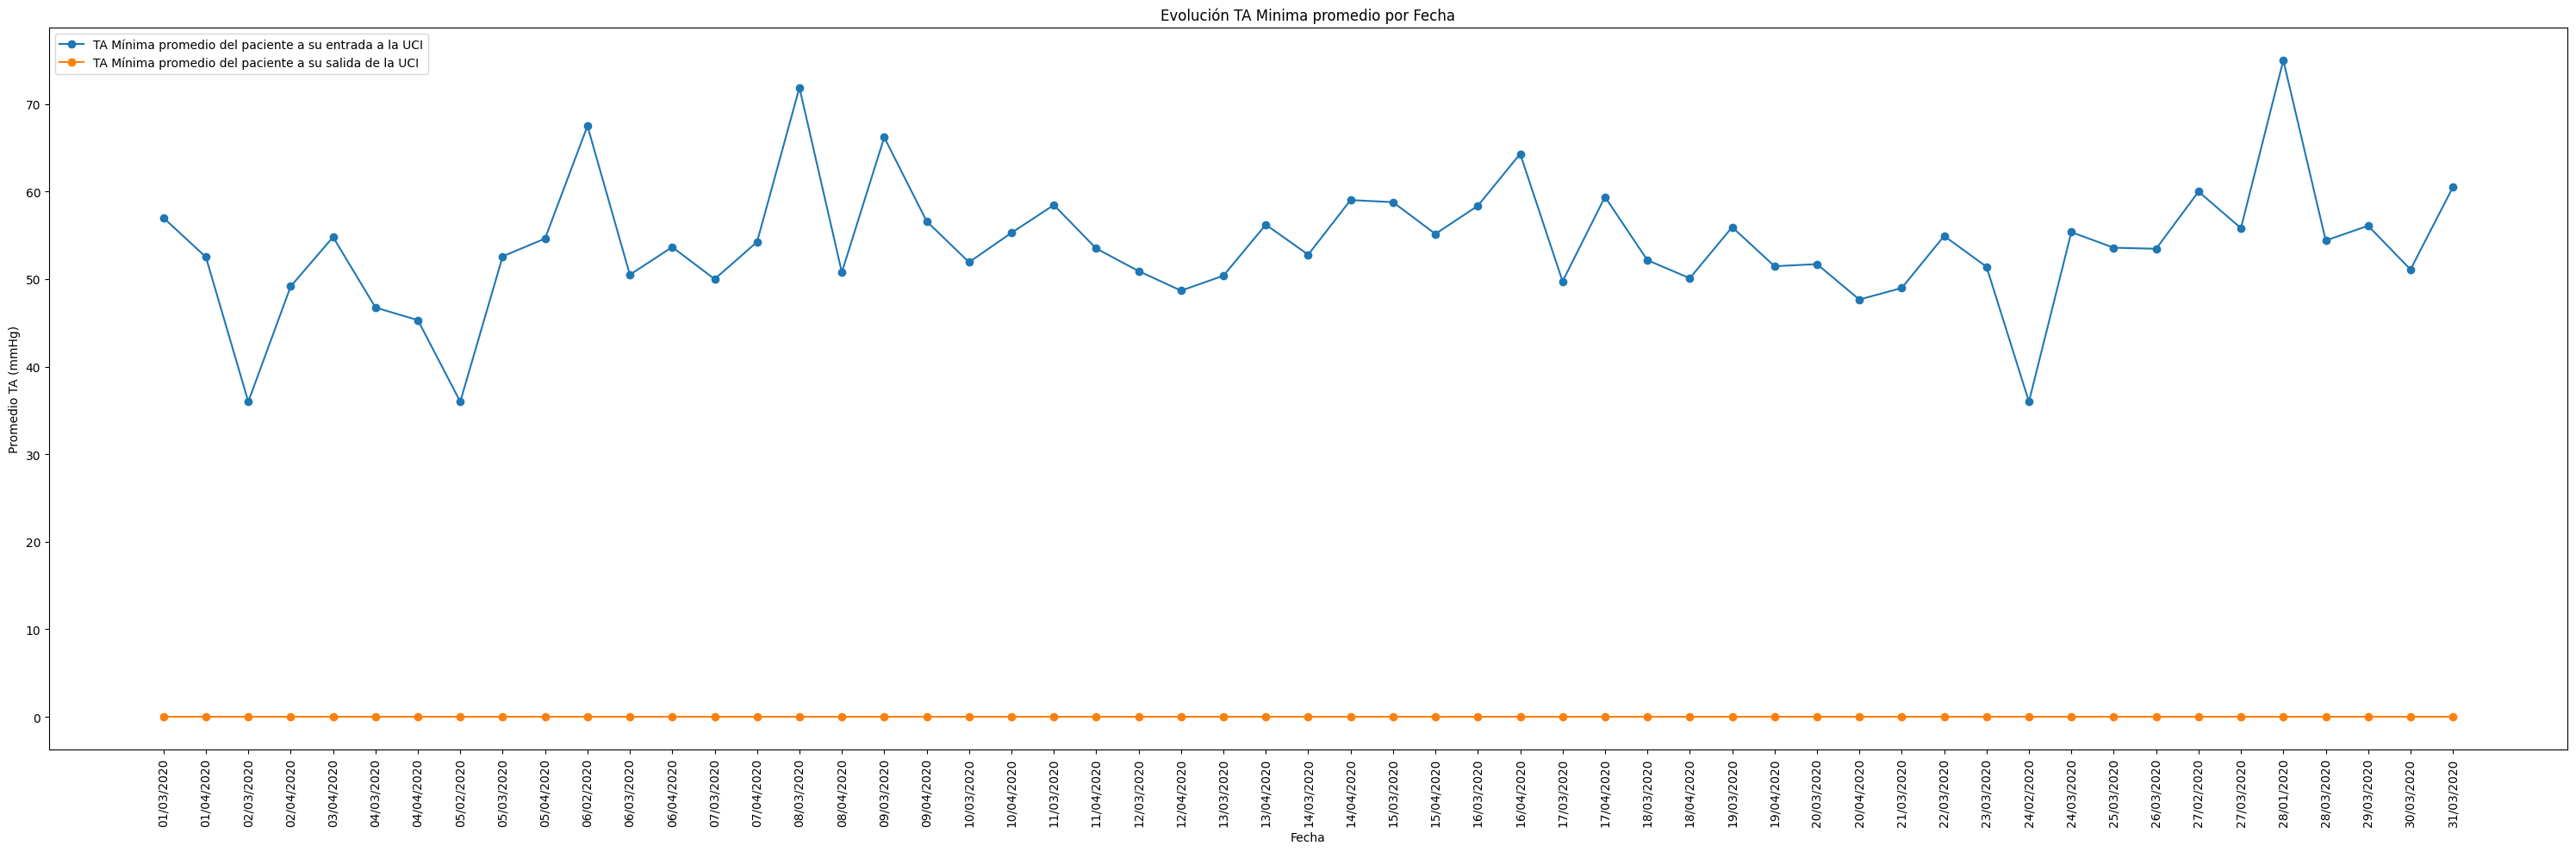

In [400]:
plt.figure(figsize=(30, 10))
plt.plot(df_const_uci_grouped['F_INGRESO/ADMISSION_D_ING/INPAT'], df_const_uci_grouped['TA_MIN_PRIMERA/FIRST_URG/EMERG'], label='TA Mínima promedio del paciente a su entrada a la UCI', marker='o')
plt.plot(df_const_uci_grouped['F_INGRESO/ADMISSION_D_ING/INPAT'], df_const_uci_grouped['TA_MIN_ULTIMA/LAST_URG/EMERG'], label='TA Mínima promedio del paciente a su salida de la UCI', marker='o')
plt.title('Evolución TA Minima promedio por Fecha')
plt.xlabel('Fecha')
plt.ylabel('Promedio TA (mmHg)')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

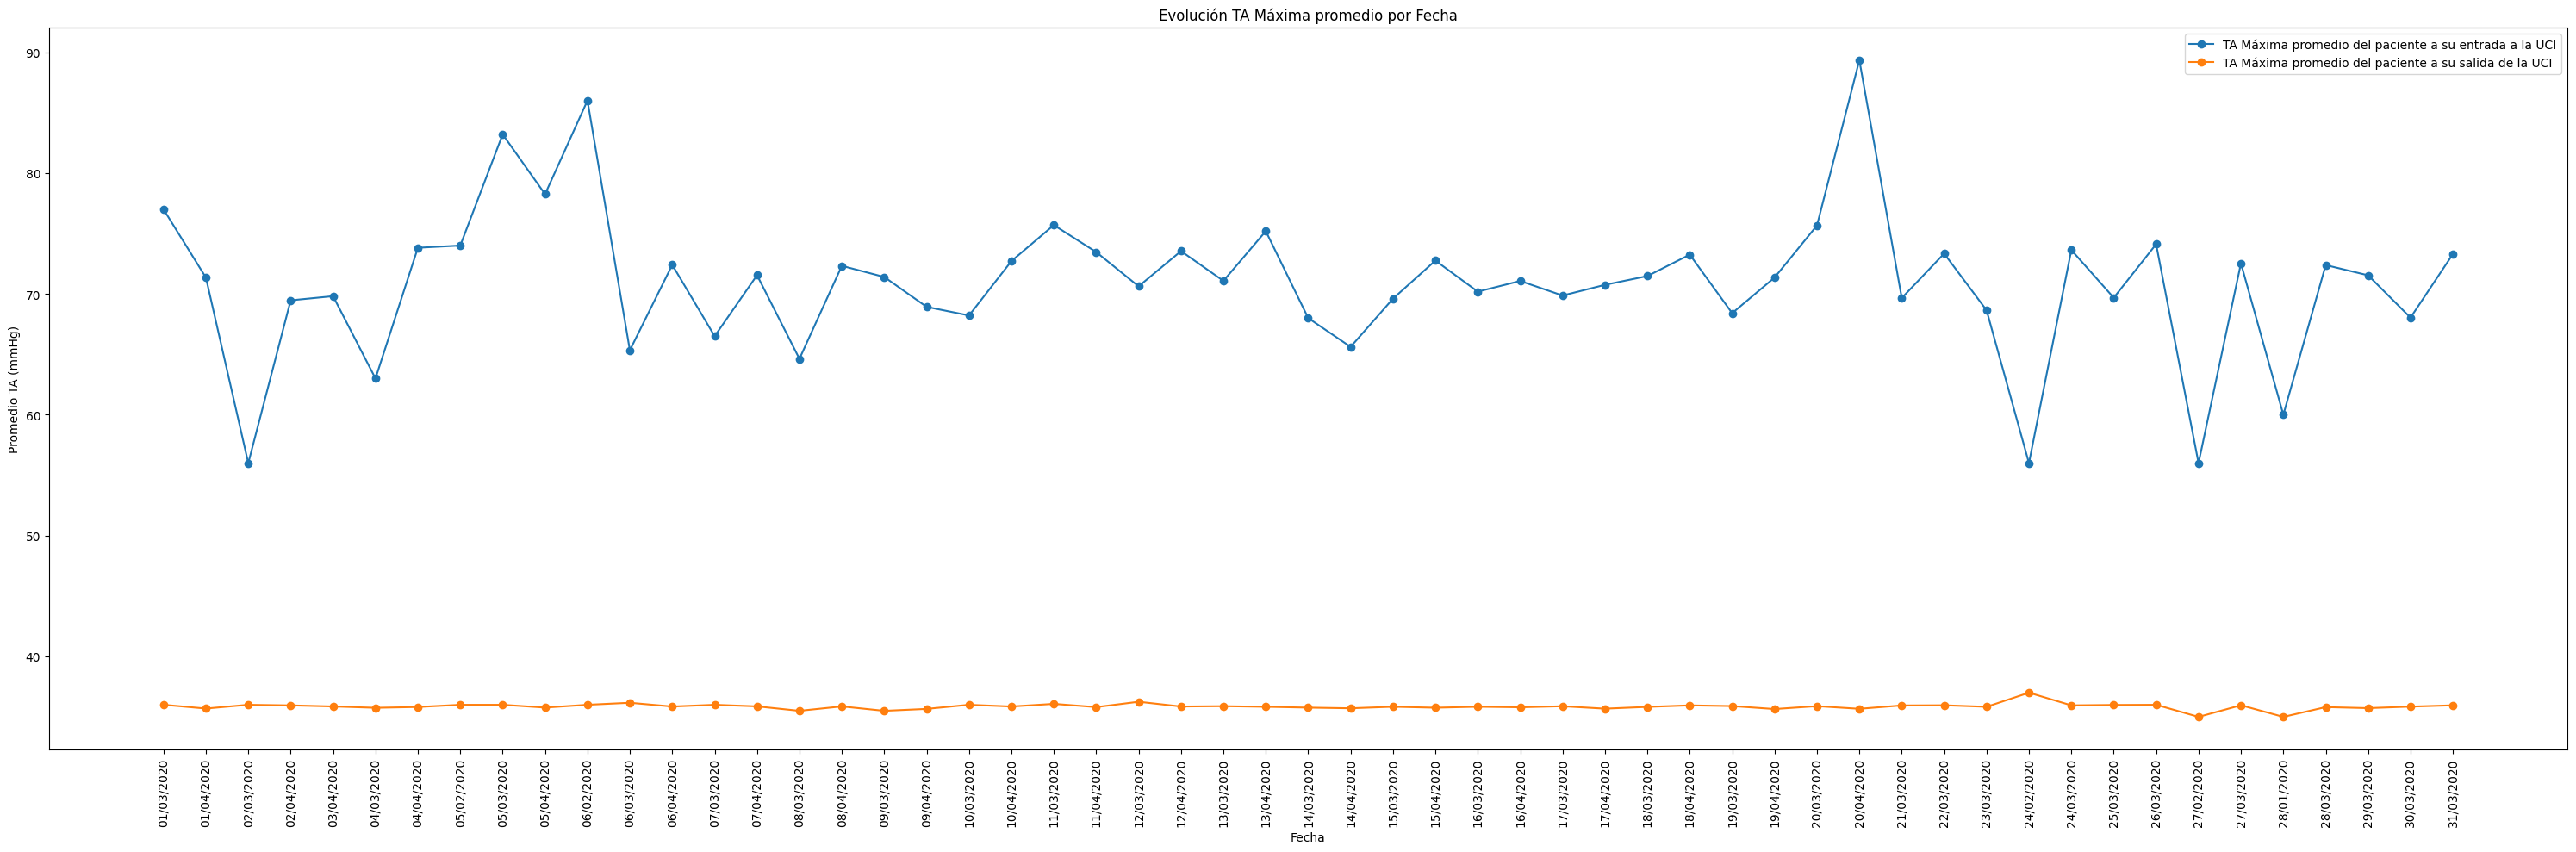

In [401]:
plt.figure(figsize=(30, 10))
plt.plot(df_const_uci_grouped['F_INGRESO/ADMISSION_D_ING/INPAT'], df_const_uci_grouped['TA_MAX_PRIMERA/FIRST/EMERG_URG'], label='TA Máxima promedio del paciente a su entrada a la UCI', marker='o')
plt.plot(df_const_uci_grouped['F_INGRESO/ADMISSION_D_ING/INPAT'], df_const_uci_grouped['TA_MAX_ULTIMA/LAST_URGEMERG'], label='TA Máxima promedio del paciente a su salida de la UCI', marker='o')
plt.title('Evolución TA Máxima promedio por Fecha')
plt.xlabel('Fecha')
plt.ylabel('Promedio TA (mmHg)')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

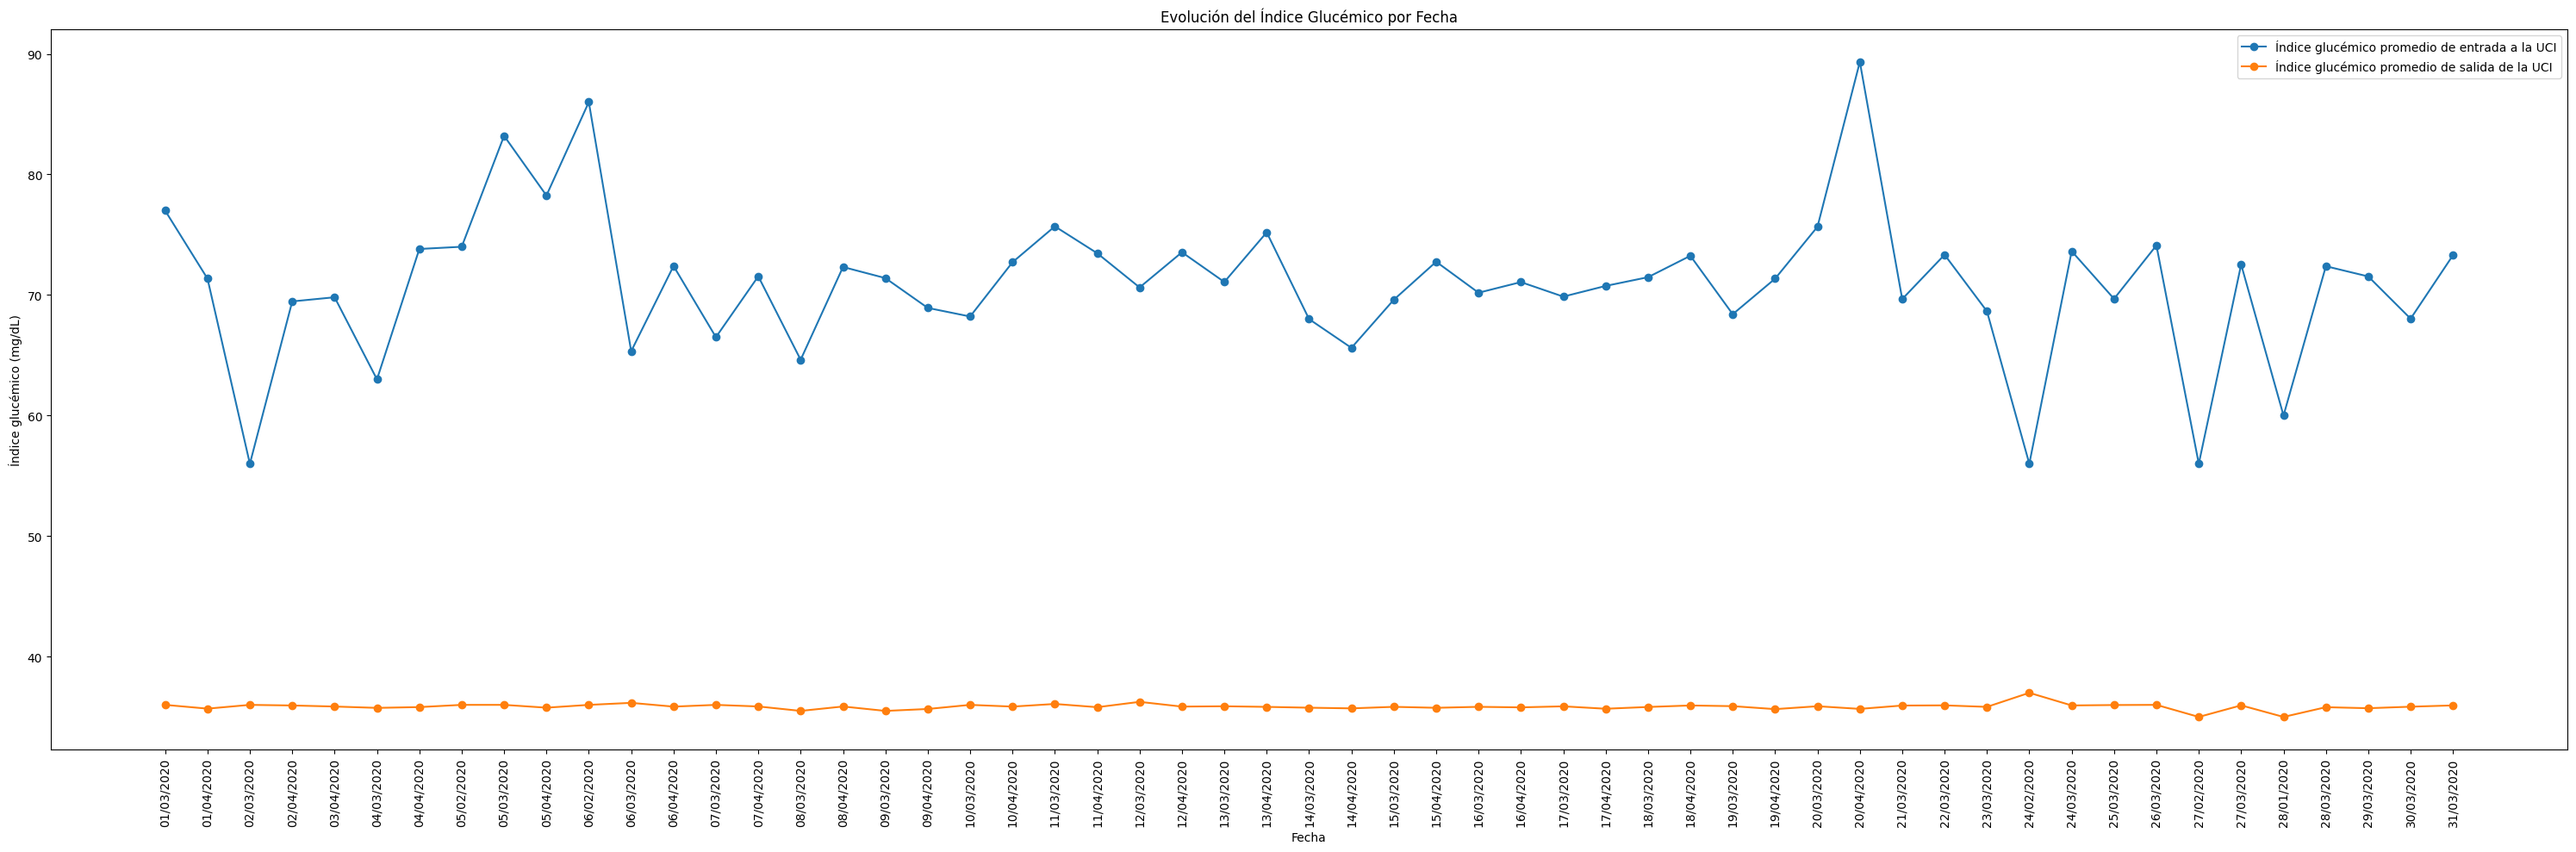

In [402]:
plt.figure(figsize=(30, 10))
plt.plot(df_const_uci_grouped['F_INGRESO/ADMISSION_D_ING/INPAT'], df_const_uci_grouped['GLU_PRIMERA/FIRST_URG/EMERG'], label='Índice glucémico promedio de entrada a la UCI', marker='o')
plt.plot(df_const_uci_grouped['F_INGRESO/ADMISSION_D_ING/INPAT'], df_const_uci_grouped['GLU_ULTIMA/LAST_URG/EMERG'], label='Índice glucémico promedio de salida de la UCI', marker='o')
plt.title('Evolución del Índice Glucémico por Fecha')
plt.xlabel('Fecha')
plt.ylabel('Índice glucémico (mg/dL)')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

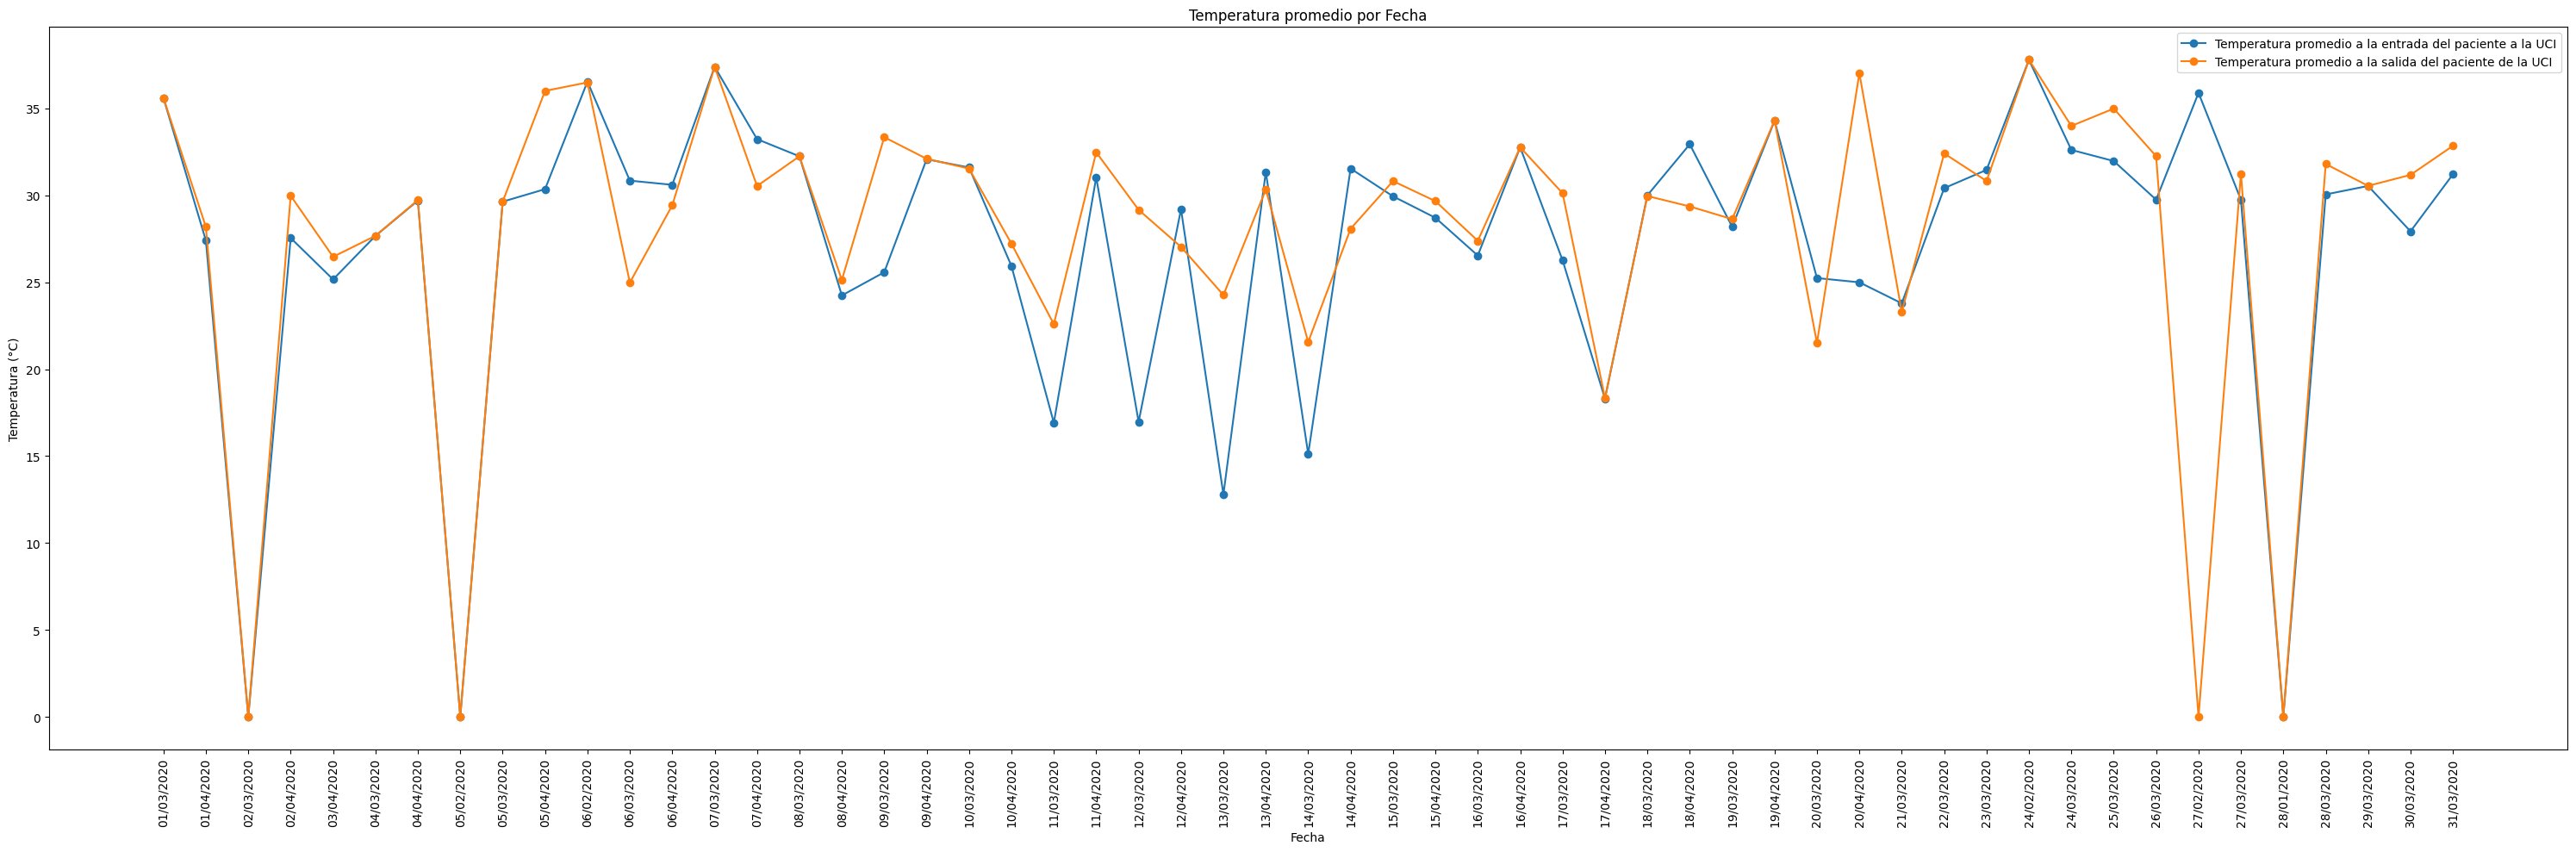

In [403]:
plt.figure(figsize=(30, 10))
plt.plot(df_const_uci_grouped['F_INGRESO/ADMISSION_D_ING/INPAT'], df_const_uci_grouped['TEMP_PRIMERA/FIRST_URG/EMERG'], label='Temperatura promedio a la entrada del paciente a la UCI', marker='o')
plt.plot(df_const_uci_grouped['F_INGRESO/ADMISSION_D_ING/INPAT'], df_const_uci_grouped['TEMP_ULTIMA/LAST_URG/EMERG'], label='Temperatura promedio a la salida del paciente de la UCI', marker='o')
plt.title('Temperatura promedio por Fecha')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°C)')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

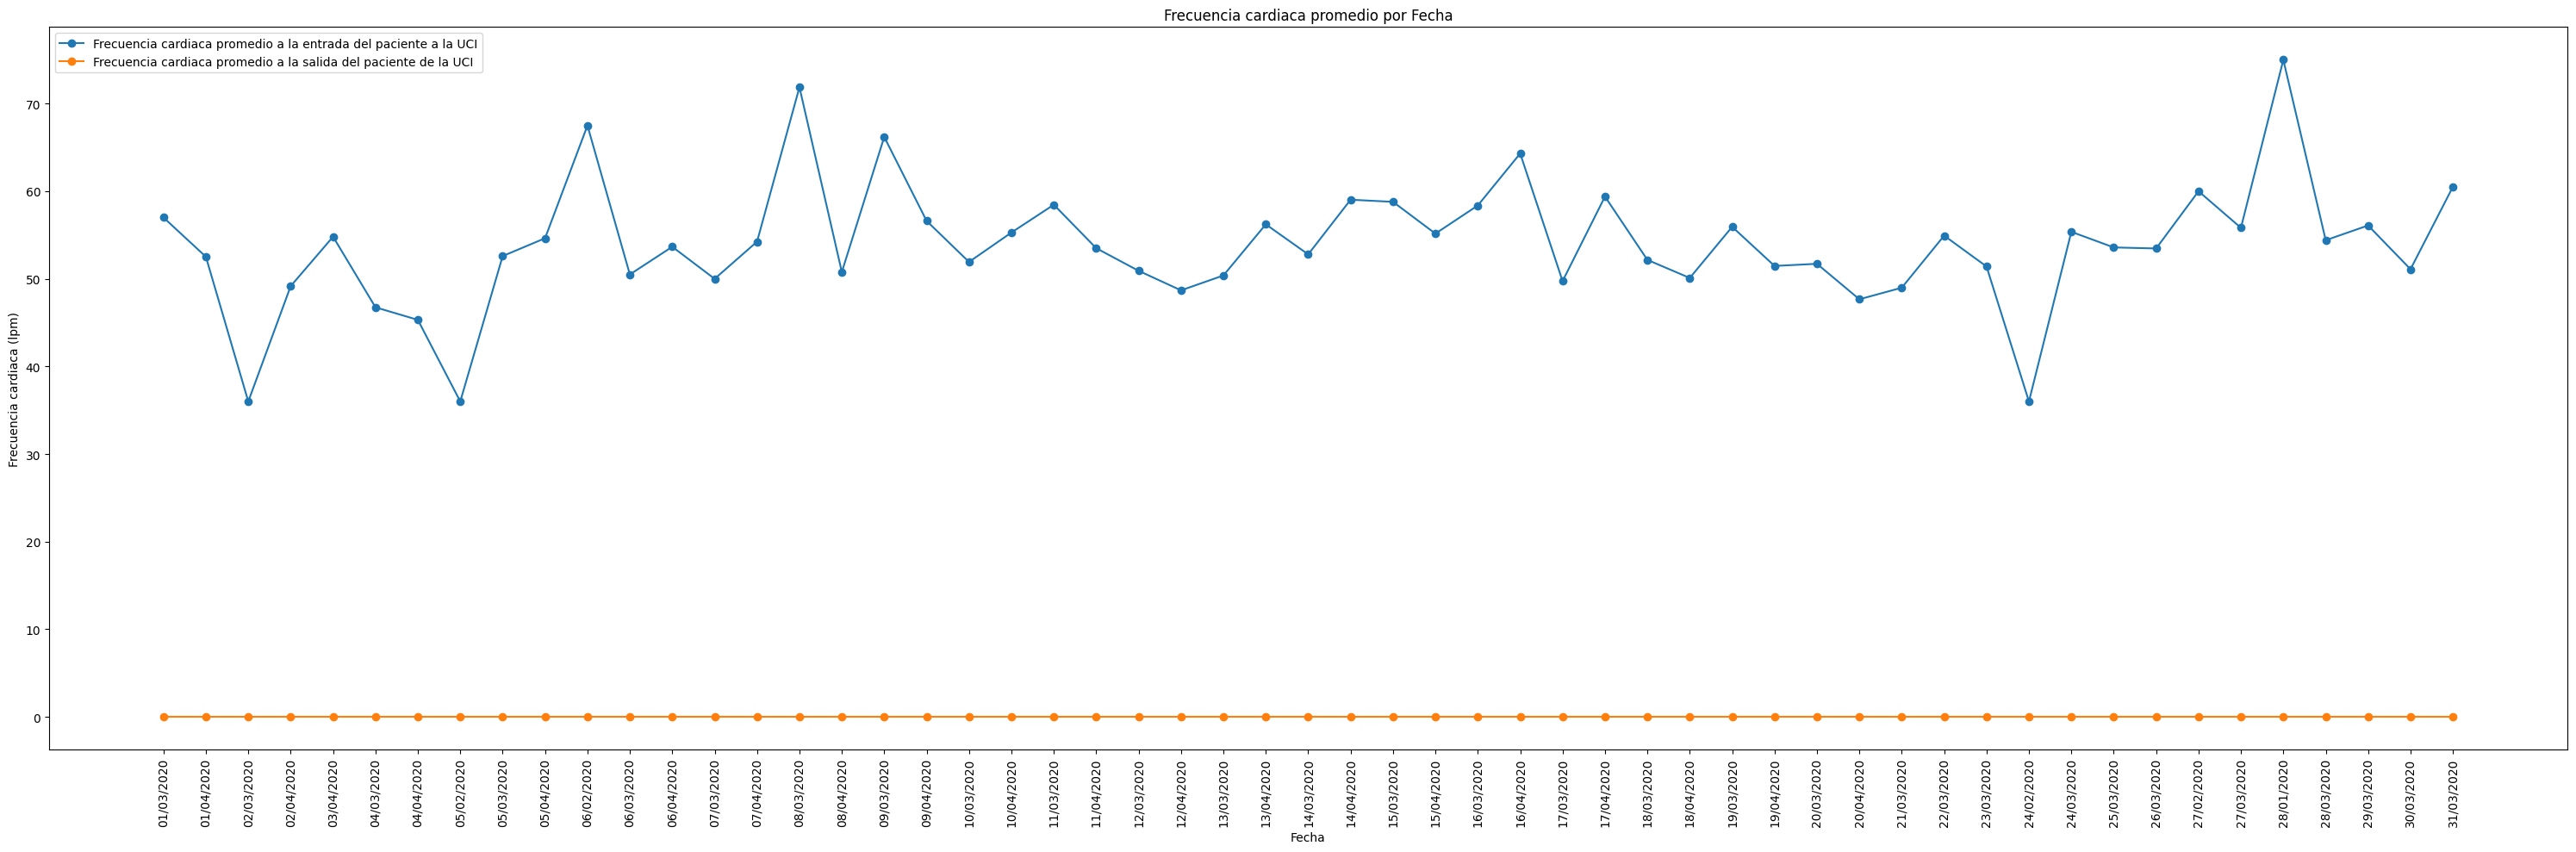

In [404]:
plt.figure(figsize=(30, 10))
plt.plot(df_const_uci_grouped['F_INGRESO/ADMISSION_D_ING/INPAT'], df_const_uci_grouped['FC/HR_PRIMERA/FIRST_URG/EMERG'], label='Frecuencia cardiaca promedio a la entrada del paciente a la UCI', marker='o')
plt.plot(df_const_uci_grouped['F_INGRESO/ADMISSION_D_ING/INPAT'], df_const_uci_grouped['FC/HR_ULTIMA/LAST_URG/EMERG'], label='Frecuencia cardiaca promedio a la salida del paciente de la UCI', marker='o')
plt.title('Frecuencia cardiaca promedio por Fecha')
plt.xlabel('Fecha')
plt.ylabel('Frecuencia cardiaca (lpm)')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

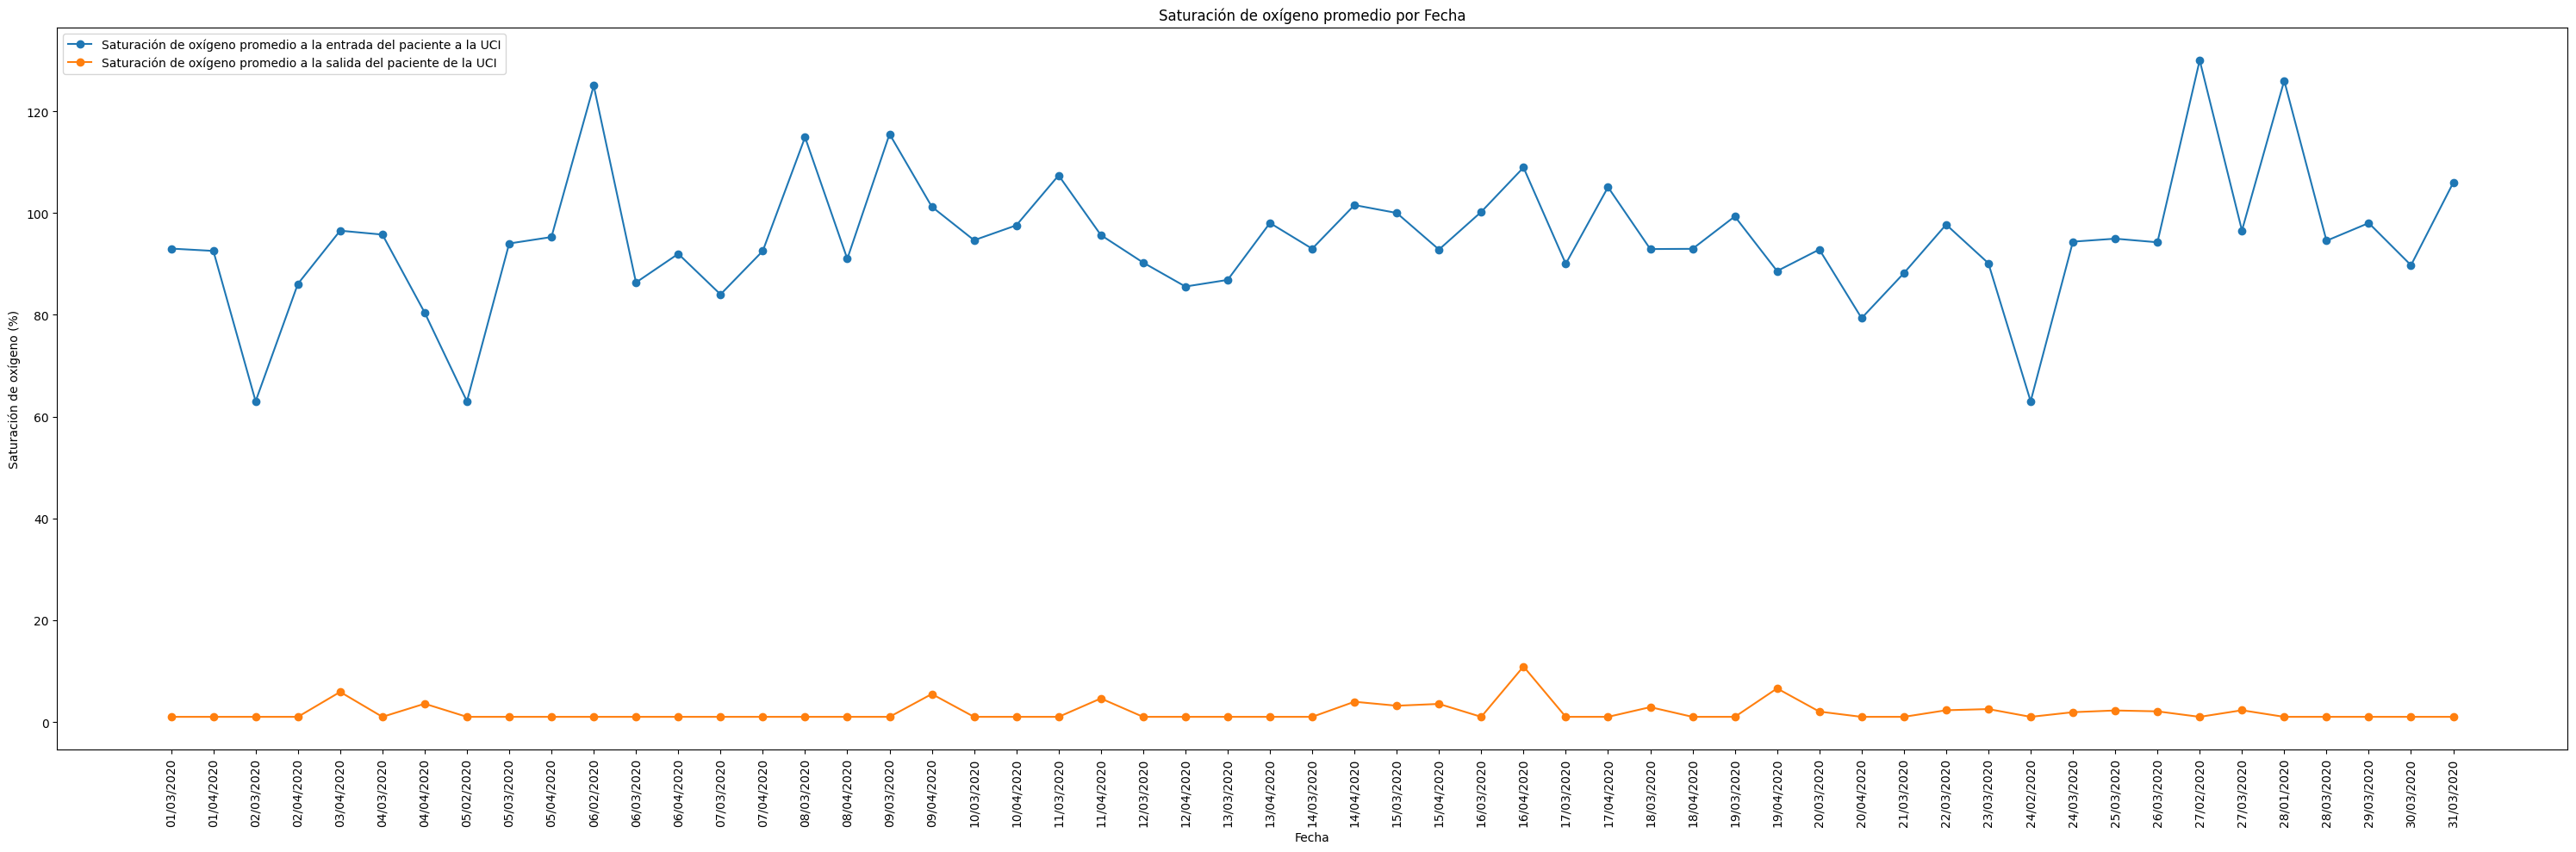

In [405]:
plt.figure(figsize=(30, 10))
plt.plot(df_const_uci_grouped['F_INGRESO/ADMISSION_D_ING/INPAT'], df_const_uci_grouped['SAT_02_PRIMERA/FIRST_URG/EMERG'], label='Saturación de oxígeno promedio a la entrada del paciente a la UCI', marker='o')
plt.plot(df_const_uci_grouped['F_INGRESO/ADMISSION_D_ING/INPAT'], df_const_uci_grouped['SAT_02_ULTIMA/LAST_URG/EMERG'], label='Saturación de oxígeno promedio a la salida del paciente de la UCI', marker='o')
plt.title('Saturación de oxígeno promedio por Fecha')
plt.xlabel('Fecha')
plt.ylabel('Saturación de oxígeno (%)')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()